Processing Bell_Pepper images...


100%|█████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:14<00:00, 102.30it/s]


Processing Blueberry images...


100%|█████████████████████████████████████████████████████████████████████████████| 1502/1502 [00:14<00:00, 103.42it/s]


Processing Tomato images...


100%|█████████████████████████████████████████████████████████████████████████████| 1591/1591 [00:15<00:00, 104.45it/s]


Processing complete!


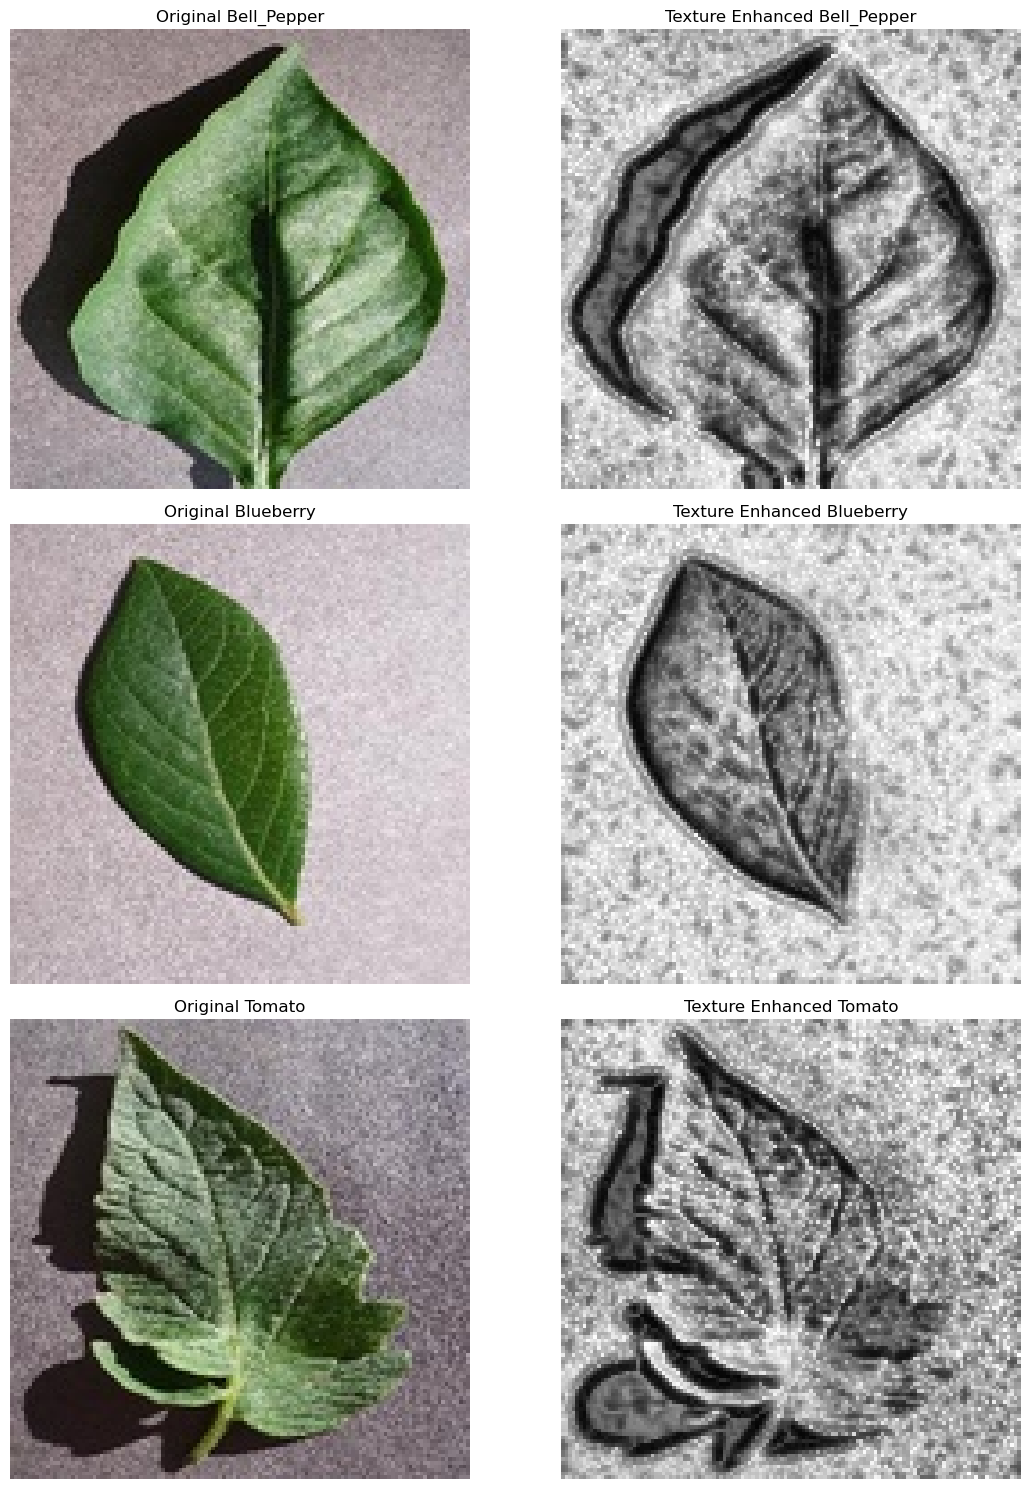

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def texture_sharpening_filter(image):
    """
    Enhanced texture sharpening filter that emphasizes texture details in images.
    This filter combines multiple techniques to enhance texture features.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 1. Laplacian sharpening
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.abs(laplacian)
    laplacian = (laplacian / laplacian.max() * 255).astype(np.uint8)
    
    # 2. Unsharp masking
    gaussian = cv2.GaussianBlur(gray, (0, 0), 3)
    unsharp_mask = cv2.addWeighted(gray, 1.5, gaussian, -0.5, 0)
    
    # 3. Bilateral filtering to preserve edges while smoothing
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 4. Detail enhancement using structure tensor
    # Calculate gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Structure tensor components
    Ixx = sobelx * sobelx
    Iyy = sobely * sobely
    Ixy = sobelx * sobely
    
    # Smooth the tensor components
    Ixx = cv2.GaussianBlur(Ixx, (5, 5), 0)
    Iyy = cv2.GaussianBlur(Iyy, (5, 5), 0)
    Ixy = cv2.GaussianBlur(Ixy, (5, 5), 0)
    
    # Calculate coherence to detect texture
    trace = Ixx + Iyy
    determinant = Ixx * Iyy - Ixy * Ixy
    
    # Avoid division by zero
    coherence = np.zeros_like(gray, dtype=np.float64)
    mask = trace > 1e-5
    coherence[mask] = (determinant[mask] / (trace[mask] ** 2))
    
    # Normalize coherence to 0-255 range
    coherence = ((coherence - coherence.min()) / 
                (coherence.max() - coherence.min() + 1e-10) * 255).astype(np.uint8)
    
    # 5. Combine all components
    # First, blend laplacian and unsharp mask
    enhanced1 = cv2.addWeighted(laplacian, 0.3, unsharp_mask, 0.7, 0)
    
    # Then, blend with bilateral filtering result
    enhanced2 = cv2.addWeighted(enhanced1, 0.7, bilateral, 0.3, 0)
    
    # Finally, blend with coherence map to emphasize texture
    texture_enhanced = cv2.addWeighted(enhanced2, 0.8, coherence, 0.2, 0)
    
    # 6. Apply adaptive histogram equalization for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_enhanced = clahe.apply(texture_enhanced)
    
    return final_enhanced

def process_dataset(input_path, output_path):
    """
    Process all images in the dataset with texture sharpening filter.
    """
    categories = ['Bell_Pepper', 'Blueberry', 'Tomato']
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for category in categories:
        input_category_path = os.path.join(input_path, category)
        output_category_path = os.path.join(output_path, category)
        
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        
        # Process each image in the category
        image_files = [f for f in os.listdir(input_category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Processing {category} images...")
        for img_file in tqdm(image_files):
            img_path = os.path.join(input_category_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue
            
            # Apply texture sharpening filter
            enhanced_img = texture_sharpening_filter(img)
            
            # Save the enhanced image
            output_img_path = os.path.join(output_category_path, img_file)
            cv2.imwrite(output_img_path, enhanced_img)
    
    print("Processing complete!")

def visualize_results(original_path, enhanced_path):
    """
    Create a visualization comparing original and enhanced images.
    """
    import matplotlib.pyplot as plt
    
    categories = ['Bell_Pepper', 'Blueberry', 'Tomato']
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    
    for i, category in enumerate(categories):
        # Get first image from category
        orig_cat_path = os.path.join(original_path, category)
        enhanced_cat_path = os.path.join(enhanced_path, category)
        
        img_files = [f for f in os.listdir(orig_cat_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if img_files:
            img_file = img_files[0]
            
            # Load original image
            orig_img = cv2.imread(os.path.join(orig_cat_path, img_file))
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            
            # Load enhanced image
            enhanced_img = cv2.imread(os.path.join(enhanced_cat_path, img_file))
            enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)
            
            # Display original
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f'Original {category}')
            axes[i, 0].axis('off')
            
            # Display enhanced
            axes[i, 1].imshow(enhanced_img)
            axes[i, 1].set_title(f'Texture Enhanced {category}')
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('texture_enhancement_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Set paths
    base_path = r"C:\Users\cutte\Downloads\Filtered Images ML Project-20250420T203315Z-001\Filtered Images ML Project"
    input_path = os.path.join(base_path, "Trimmed Original Images", "images")
    output_path = os.path.join(base_path, "texture_sharpening")
    
    # Process dataset
    process_dataset(input_path, output_path)
    
    # Create visualization
    visualize_results(input_path, output_path)

Loading and processing images...
Total images in labels.csv: 4571


Processing ORIGINAL features

Data shape: (4571, 692)
Labels shape: (4571,)
Applying PCA to reduce features from 692 to 50
Explained variance ratio: 0.8750

Training SVM with original features...
Validation accuracy: 0.9973

SVM Performance:
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F1-score: 0.9989
R-squared: 0.9971
Best parameters: {'C': 10, 'gamma': 'scale'}
Cross-validation scores: [0.9982906  0.9965812  0.9982906  0.99487179 0.99828767]
Mean CV score: 0.9973 (+/- 0.0027)


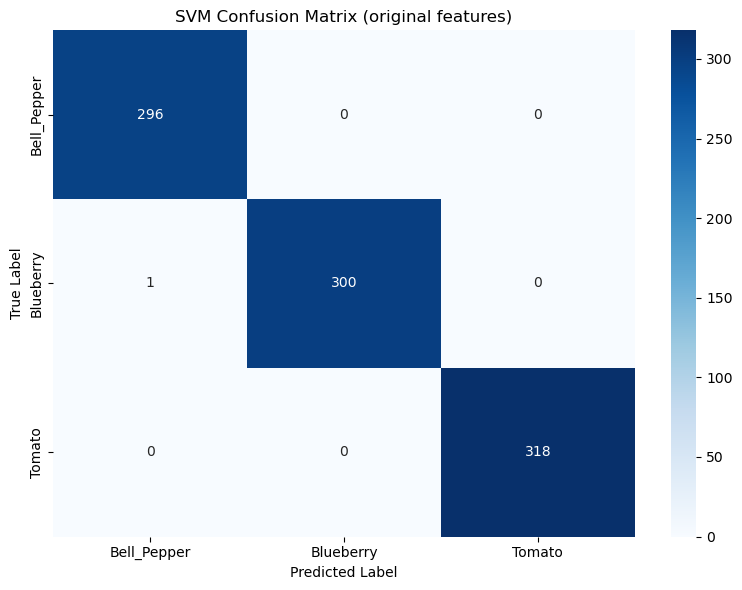


Detailed Classification Report:
              precision    recall  f1-score   support

 Bell_Pepper       1.00      1.00      1.00       296
   Blueberry       1.00      1.00      1.00       301
      Tomato       1.00      1.00      1.00       318

    accuracy                           1.00       915
   macro avg       1.00      1.00      1.00       915
weighted avg       1.00      1.00      1.00       915


Training Neural Network with original features...
Validation accuracy: 0.9986

Neural Network Performance:
Accuracy: 0.9978
Precision: 0.9978
Recall: 0.9978
F1-score: 0.9978
R-squared: 0.9952
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 300}
Cross-validation scores: [0.9982906  1.         0.9982906  0.99316239 0.99657534]
Mean CV score: 0.9973 (+/- 0.0046)

Training Decision Tree with original features...
Validation accuracy: 0.9235

Decision Tree Performance:
Accuracy: 0.9257
Precision: 0.9259
Recall: 0.9251
F1-score:

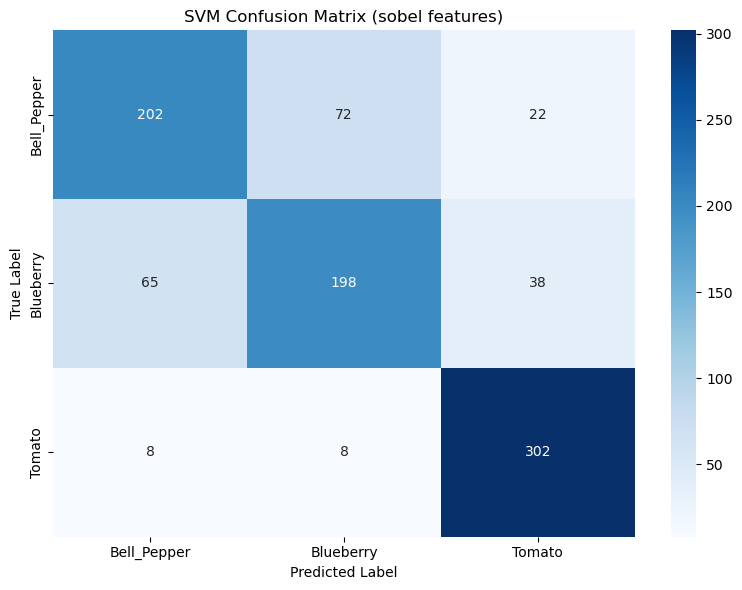


Detailed Classification Report:
              precision    recall  f1-score   support

 Bell_Pepper       0.73      0.68      0.71       296
   Blueberry       0.71      0.66      0.68       301
      Tomato       0.83      0.95      0.89       318

    accuracy                           0.77       915
   macro avg       0.76      0.76      0.76       915
weighted avg       0.76      0.77      0.76       915


Training Neural Network with sobel features...
Validation accuracy: 0.7596

Neural Network Performance:
Accuracy: 0.7661
Precision: 0.7617
Recall: 0.7633
F1-score: 0.7623
R-squared: 0.5010
Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 300}
Cross-validation scores: [0.73675214 0.71282051 0.71623932 0.74017094 0.75513699]
Mean CV score: 0.7322 (+/- 0.0315)

Training Decision Tree with sobel features...
Validation accuracy: 0.6380

Decision Tree Performance:
Accuracy: 0.6579
Precision: 0.6547
Recall: 0.6536
F1-score: 0.6498


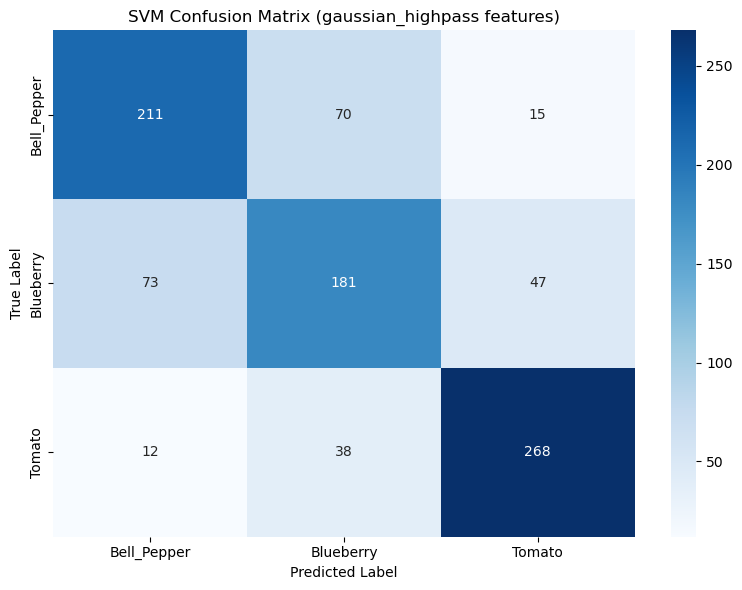


Detailed Classification Report:
              precision    recall  f1-score   support

 Bell_Pepper       0.71      0.71      0.71       296
   Blueberry       0.63      0.60      0.61       301
      Tomato       0.81      0.84      0.83       318

    accuracy                           0.72       915
   macro avg       0.72      0.72      0.72       915
weighted avg       0.72      0.72      0.72       915


Training Neural Network with gaussian_highpass features...
Validation accuracy: 0.6817

Neural Network Performance:
Accuracy: 0.6918
Precision: 0.6863
Recall: 0.6892
F1-score: 0.6874
R-squared: 0.3739
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 300}
Cross-validation scores: [0.7008547  0.68547009 0.7025641  0.6974359  0.68835616]
Mean CV score: 0.6949 (+/- 0.0136)

Training Decision Tree with gaussian_highpass features...
Validation accuracy: 0.6352

Decision Tree Performance:
Accuracy: 0.6634
Precision: 0.6673
Recall: 

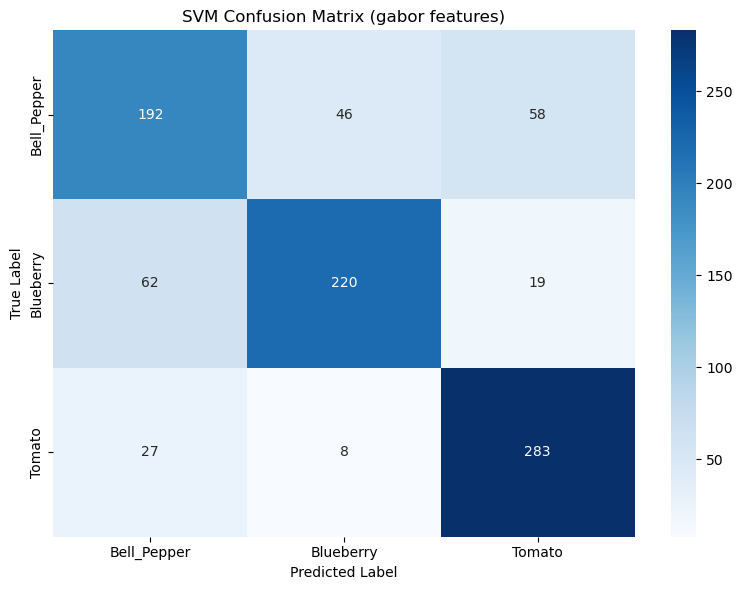


Detailed Classification Report:
              precision    recall  f1-score   support

 Bell_Pepper       0.68      0.65      0.67       296
   Blueberry       0.80      0.73      0.77       301
      Tomato       0.79      0.89      0.83       318

    accuracy                           0.76       915
   macro avg       0.76      0.76      0.76       915
weighted avg       0.76      0.76      0.76       915


Training Neural Network with gabor features...
Validation accuracy: 0.7705

Neural Network Performance:
Accuracy: 0.7650
Precision: 0.7615
Recall: 0.7619
F1-score: 0.7600
R-squared: 0.5380
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 300}
Cross-validation scores: [0.73333333 0.7982906  0.78974359 0.76752137 0.7619863 ]
Mean CV score: 0.7702 (+/- 0.0456)

Training Decision Tree with gabor features...
Validation accuracy: 0.6762

Decision Tree Performance:
Accuracy: 0.6721
Precision: 0.6686
Recall: 0.6694
F1-score: 0.668

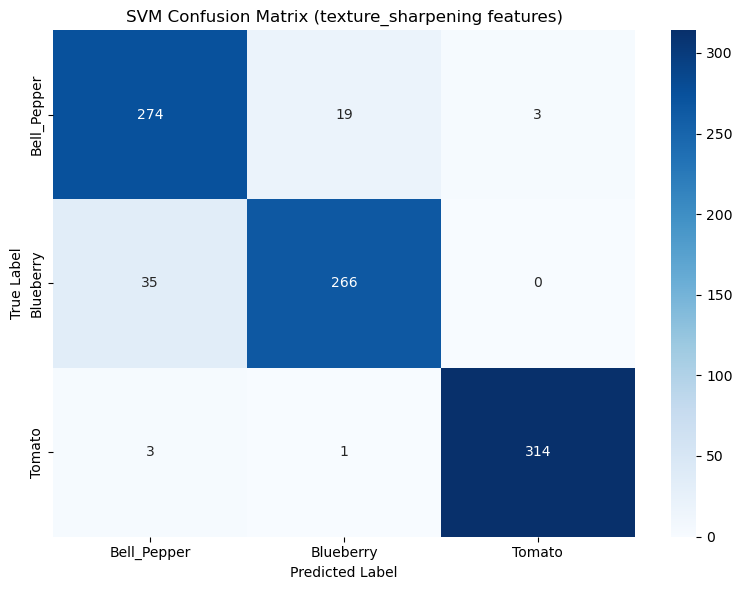


Detailed Classification Report:
              precision    recall  f1-score   support

 Bell_Pepper       0.88      0.93      0.90       296
   Blueberry       0.93      0.88      0.91       301
      Tomato       0.99      0.99      0.99       318

    accuracy                           0.93       915
   macro avg       0.93      0.93      0.93       915
weighted avg       0.93      0.93      0.93       915


Training Neural Network with texture_sharpening features...
Validation accuracy: 0.9508

Neural Network Performance:
Accuracy: 0.9355
Precision: 0.9346
Recall: 0.9344
F1-score: 0.9342
R-squared: 0.8713
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 300}
Cross-validation scores: [0.94188034 0.94700855 0.91452991 0.94017094 0.94006849]
Mean CV score: 0.9367 (+/- 0.0228)

Training Decision Tree with texture_sharpening features...
Validation accuracy: 0.8661

Decision Tree Performance:
Accuracy: 0.8689
Precision: 0.8689
Recall

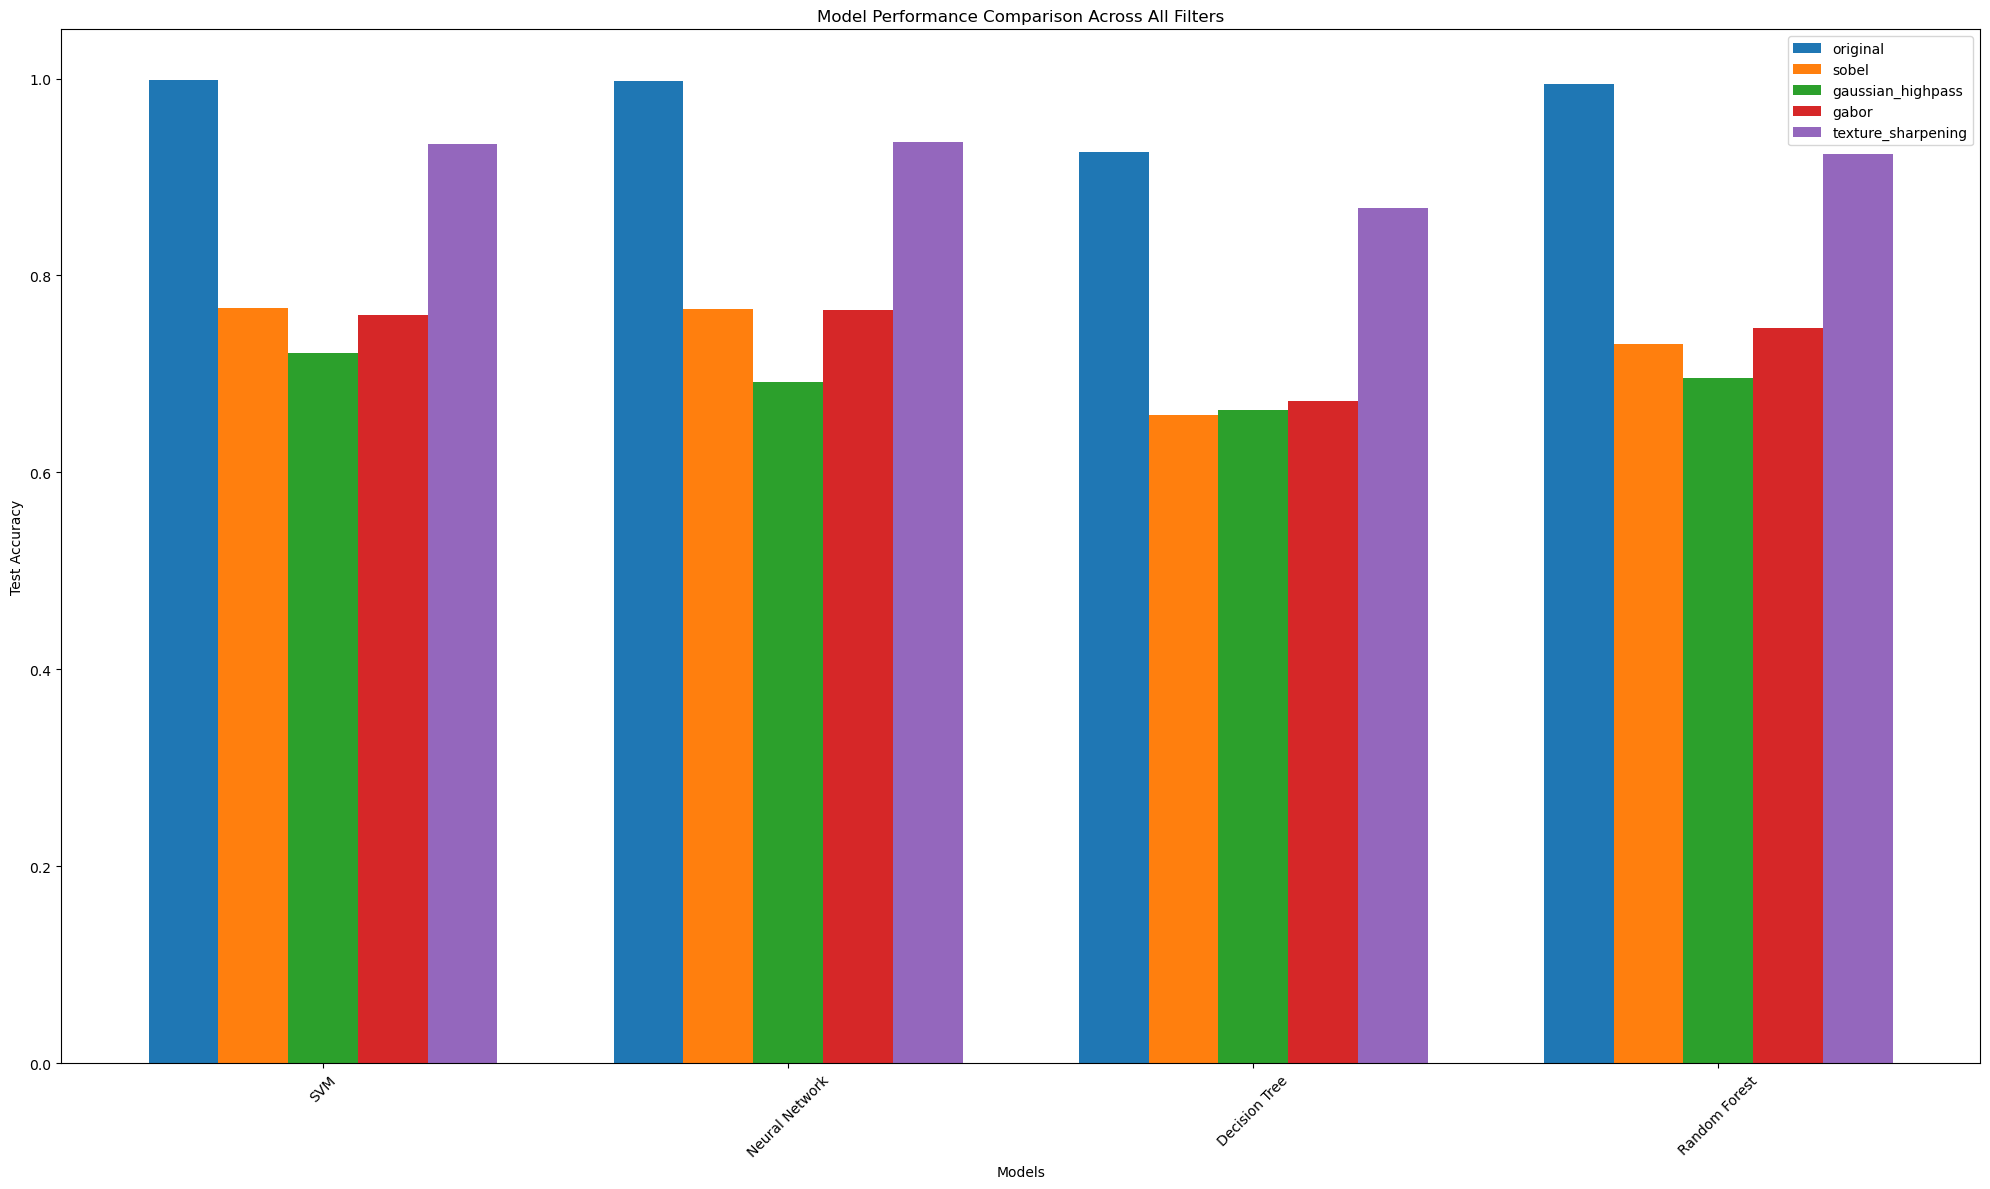


BEST AND WORST PERFORMING COMBINATIONS

Best Combination:
  Filter: original
  Model: SVM
  Test Accuracy: 0.9989
  F1-score: 0.9989

Worst Combination:
  Filter: sobel
  Model: Decision Tree
  Test Accuracy: 0.6579
  F1-score: 0.6498

Results have been saved to 'comprehensive_results_summary.csv'


In [23]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import local_binary_pattern
from scipy import ndimage
import warnings
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pickle
warnings.filterwarnings('ignore')

# Set the paths to your data
base_path = r"C:\Users\cutte\Downloads\Filtered Images ML Project-20250420T203315Z-001\Filtered Images ML Project"
original_images_path = os.path.join(base_path, "Trimmed Original Images", "images")
gaussian_path = os.path.join(base_path, "gaussian_highpass")
sobel_path = os.path.join(base_path, "sobel")
gabor_path = os.path.join(base_path, "gabor")
texture_sharpening_path = os.path.join(base_path, "texture_sharpening")  # Added texture_sharpening path

# Categories
categories = ['Bell_Pepper', 'Blueberry', 'Tomato']

# Image size for resizing
IMG_SIZE = 128

def extract_color_histogram(image):
    """Extract color histogram features from HSV color space"""
    if len(image.shape) == 3:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    else:
        return np.zeros(256)  # Return empty features for grayscale
    
    # Calculate histograms for each channel
    hist_h = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalize histograms
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()
    
    # Concatenate histograms
    hist_features = np.concatenate([hist_h, hist_s, hist_v])
    
    return hist_features

def extract_edge_features(image):
    """Extract edge-based features"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Canny edge detection
    edges = cv2.Canny(image, 100, 200)
    
    # Calculate edge density
    edge_density = np.sum(edges > 0) / edges.size
    
    # Calculate edge orientation histogram
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
    edge_angle = np.arctan2(sobely, sobelx) * 180 / np.pi
    
    # Create orientation histogram
    hist_bins = 18  # 20-degree bins
    orientation_hist = np.histogram(edge_angle[edge_magnitude > 0], bins=hist_bins, range=(-180, 180))[0]
    orientation_hist = orientation_hist / (np.sum(orientation_hist) + 1e-7)
    
    # Combine features
    edge_features = np.concatenate([[edge_density], orientation_hist])
    
    return edge_features

def extract_simple_texture_features(image):
    """Extract simple texture features without GLCM"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    features = []
    
    # 1. Variance (texture roughness)
    variance = np.var(image)
    features.append(variance)
    
    # 2. Standard deviation
    std_dev = np.std(image)
    features.append(std_dev)
    
    # 3. Range (max - min)
    range_val = np.ptp(image)
    features.append(range_val)
    
    # 4. Entropy
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten() / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-7))
    features.append(entropy)
    
    # 5. Gradient magnitude features
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    gradient_mean = np.mean(gradient_magnitude)
    gradient_std = np.std(gradient_magnitude)
    features.extend([gradient_mean, gradient_std])
    
    # 6. Laplacian features (edge/texture sharpness)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    laplacian_mean = np.mean(np.abs(laplacian))
    laplacian_std = np.std(laplacian)
    features.extend([laplacian_mean, laplacian_std])
    
    # 7. Local statistics (in windows)
    window_size = 16
    local_means = []
    local_stds = []
    
    for i in range(0, image.shape[0] - window_size, window_size):
        for j in range(0, image.shape[1] - window_size, window_size):
            window = image[i:i+window_size, j:j+window_size]
            local_means.append(np.mean(window))
            local_stds.append(np.std(window))
    
    features.append(np.mean(local_means))
    features.append(np.std(local_means))
    features.append(np.mean(local_stds))
    features.append(np.std(local_stds))
    
    return np.array(features)

def load_and_preprocess_images(path, categories, img_size, filter_type='original'):
    """Load images and extract features based on filter type"""
    data = []
    labels = []
    
    # Create a color mapping for consistency
    category_mapping = {cat: idx for idx, cat in enumerate(categories)}
    
    for category_idx, category in enumerate(categories):
        category_path = os.path.join(path, category)
        if not os.path.exists(category_path):
            print(f"Warning: Path {category_path} does not exist!")
            continue
        
        for img_name in os.listdir(category_path):
            # Skip non-image files
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            try:
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                
                # Resize image
                img = cv2.resize(img, (img_size, img_size))
                
                # Extract features based on filter type
                if filter_type == 'original':
                    features = extract_color_histogram(img)
                elif filter_type in ['edge', 'sobel', 'gaussian_highpass']:
                    features = extract_edge_features(img)
                elif filter_type in ['texture_sharpening', 'gabor']:
                    features = extract_simple_texture_features(img)
                else:
                    features = extract_color_histogram(img)  # Default
                
                data.append(features)
                labels.append(category_idx)
                
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue
    
    return np.array(data), np.array(labels)

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model with additional metrics"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Calculate R-squared
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
        y_test_binary = np.eye(len(np.unique(y_test)))[y_test]
        r2 = r2_score(y_test_binary, y_prob)
    else:
        r2 = None
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    if r2 is not None:
        print(f"R-squared: {r2:.4f}")
    
    return accuracy, precision, recall, f1, r2, y_pred

def plot_confusion_matrix(y_true, y_pred, categories, title):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Loading and processing images...")
    
    # Load CSV file for label verification
    labels_path = os.path.join(base_path, "Trimmed Original Images", "labels.csv")
    if os.path.exists(labels_path):
        labels_df = pd.read_csv(labels_path)
        print(f"Total images in labels.csv: {len(labels_df)}")
    
    # MODIFIED: Define filter types to process (using all available filters)
    filter_configs = {
        'original': {'path': original_images_path, 'type': 'original'},
        'sobel': {'path': sobel_path, 'type': 'sobel'},
        'gaussian_highpass': {'path': gaussian_path, 'type': 'gaussian_highpass'},
        'gabor': {'path': gabor_path, 'type': 'gabor'},
        'texture_sharpening': {'path': texture_sharpening_path, 'type': 'texture_sharpening'}
    }
    
    all_results = {}
    
    for filter_name, config in filter_configs.items():
        print(f"\n\n{'='*50}")
        print(f"Processing {filter_name.upper()} features")
        print(f"{'='*50}\n")
        
        # Check if path exists before processing
        if not os.path.exists(config['path']):
            print(f"Path not found: {config['path']}")
            continue
        
        # Load data from the appropriate directory
        X, y = load_and_preprocess_images(config['path'], categories, IMG_SIZE, config['type'])
        
        if X.shape[0] == 0:
            print(f"No data loaded for {filter_name}. Skipping...")
            continue
        
        print(f"Data shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        
        # Split data with stratification
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)
        
        # Further split for validation to detect overfitting
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=77, stratify=y_train)
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Apply PCA to reduce dimensionality if features are too many
        if X_train_scaled.shape[1] > 100:
            print(f"Applying PCA to reduce features from {X_train_scaled.shape[1]} to 50")
            pca = PCA(n_components=50)
            X_train_scaled = pca.fit_transform(X_train_scaled)
            X_val_scaled = pca.transform(X_val_scaled)
            X_test_scaled = pca.transform(X_test_scaled)
            print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
        
        # Define models
        models = {
            'SVM': {
                'model': svm.SVC(probability=True, kernel='rbf'),
                'param_grid': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto']
                }
            },
            'Neural Network': {
                'model': MLPClassifier(random_state=77),
                'param_grid': {
                    'hidden_layer_sizes': [(50,), (100,)],
                    'alpha': [0.0001, 0.001, 0.01],
                    'learning_rate': ['constant', 'adaptive'],
                    'max_iter': [300]
                }
            },
            'Decision Tree': {
                'model': DecisionTreeClassifier(random_state=77),
                'param_grid': {
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [5, 10, 20],
                    'min_samples_leaf': [2, 5, 10],
                    'criterion': ['gini', 'entropy']
                }
            },
            'Random Forest': {
                'model': RandomForestClassifier(random_state=77),
                'param_grid': {
                    'n_estimators': [50, 100],
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [5, 10, 20],
                    'min_samples_leaf': [2, 5, 10]
                }
            }
        }
        
        filter_results = {}
        
        for model_name, model_info in models.items():
            print(f"\nTraining {model_name} with {filter_name} features...")
            
            # Grid search for hyperparameter tuning
            grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], cv=5, n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            
            # Validate on validation set to check for overfitting
            y_val_pred = grid_search.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, y_val_pred)
            print(f"Validation accuracy: {val_acc:.4f}")
            
            # Test on test set
            accuracy, precision, recall, f1, r2, y_pred = train_and_evaluate_model(
                grid_search, X_train_scaled, X_test_scaled, y_train, y_test, model_name
            )
            
            print(f"Best parameters: {grid_search.best_params_}")
            
            # Cross-validation to check consistency
            cv_scores = cross_val_score(grid_search.best_estimator_, X_train_scaled, y_train, cv=5)
            print(f"Cross-validation scores: {cv_scores}")
            print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            # Store results
            filter_results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'r2': r2,
                'val_accuracy': val_acc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'best_params': grid_search.best_params_
            }
            
            # Plot confusion matrix for SVM
            if model_name == 'SVM':
                plot_confusion_matrix(y_test, y_pred, categories, 
                                    f'{model_name} Confusion Matrix ({filter_name} features)')
                
                # Print detailed classification report
                print("\nDetailed Classification Report:")
                print(classification_report(y_test, y_pred, target_names=categories))
        
        all_results[filter_name] = filter_results
    
    # Summary of results
    print("\n\n" + "="*70)
    print("FINAL SUMMARY REPORT - ALL FILTERS")
    print("="*70 + "\n")
    
    results_summary = []
    
    for filter_name, results in all_results.items():
        print(f"\n{filter_name.upper()} Features:")
        print("-" * 50)
        for model_name, metrics in results.items():
            print(f"{model_name}:")
            print(f"  Test Accuracy: {metrics['accuracy']:.4f}")
            print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
            print(f"  CV Mean: {metrics['cv_mean']:.4f} (+/- {metrics['cv_std'] * 2:.4f})")
            print(f"  F1-score: {metrics['f1']:.4f}")
            if metrics['r2'] is not None:
                print(f"  R-squared: {metrics['r2']:.4f}")
            print(f"  Best params: {metrics['best_params']}")
            
            # Check for overfitting
            overfit_gap = metrics['accuracy'] - metrics['val_accuracy']
            if overfit_gap > 0.05:
                print(f"  ⚠️ WARNING: Possible overfitting (gap={overfit_gap:.4f})")
            print()
            
            # Collect results for summary
            results_summary.append({
                'Filter': filter_name,
                'Model': model_name,
                'Test Accuracy': metrics['accuracy'],
                'Validation Accuracy': metrics['val_accuracy'],
                'CV Mean': metrics['cv_mean'],
                'F1-score': metrics['f1']
            })
    
    # Create DataFrame from summary
    results_df = pd.DataFrame(results_summary)
    results_df.to_csv('comprehensive_results_summary.csv', index=False)
    
    # Create visualization of results
    plt.figure(figsize=(20, 12))
    
    # Filter comparison plot
    unique_filters = results_df['Filter'].unique()
    unique_models = results_df['Model'].unique()
    
    bar_width = 0.15
    x = np.arange(len(unique_models))
    
    for i, filter_type in enumerate(unique_filters):
        data = results_df[results_df['Filter'] == filter_type]
        plt.bar(x + i*bar_width, data['Test Accuracy'], bar_width, label=filter_type)
    
    plt.xlabel('Models')
    plt.ylabel('Test Accuracy')
    plt.title('Model Performance Comparison Across All Filters')
    plt.xticks(x + bar_width * 2, unique_models, rotation=45)
    plt.legend()
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig('all_filters_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find best and worst combinations
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    worst_result = results_df.loc[results_df['Test Accuracy'].idxmin()]
    
    print("\n" + "="*70)
    print("BEST AND WORST PERFORMING COMBINATIONS")
    print("="*70 + "\n")
    
    print(f"Best Combination:")
    print(f"  Filter: {best_result['Filter']}")
    print(f"  Model: {best_result['Model']}")
    print(f"  Test Accuracy: {best_result['Test Accuracy']:.4f}")
    print(f"  F1-score: {best_result['F1-score']:.4f}")
    
    print(f"\nWorst Combination:")
    print(f"  Filter: {worst_result['Filter']}")
    print(f"  Model: {worst_result['Model']}")
    print(f"  Test Accuracy: {worst_result['Test Accuracy']:.4f}")
    print(f"  F1-score: {worst_result['F1-score']:.4f}")
    
    print("\nResults have been saved to 'comprehensive_results_summary.csv'")

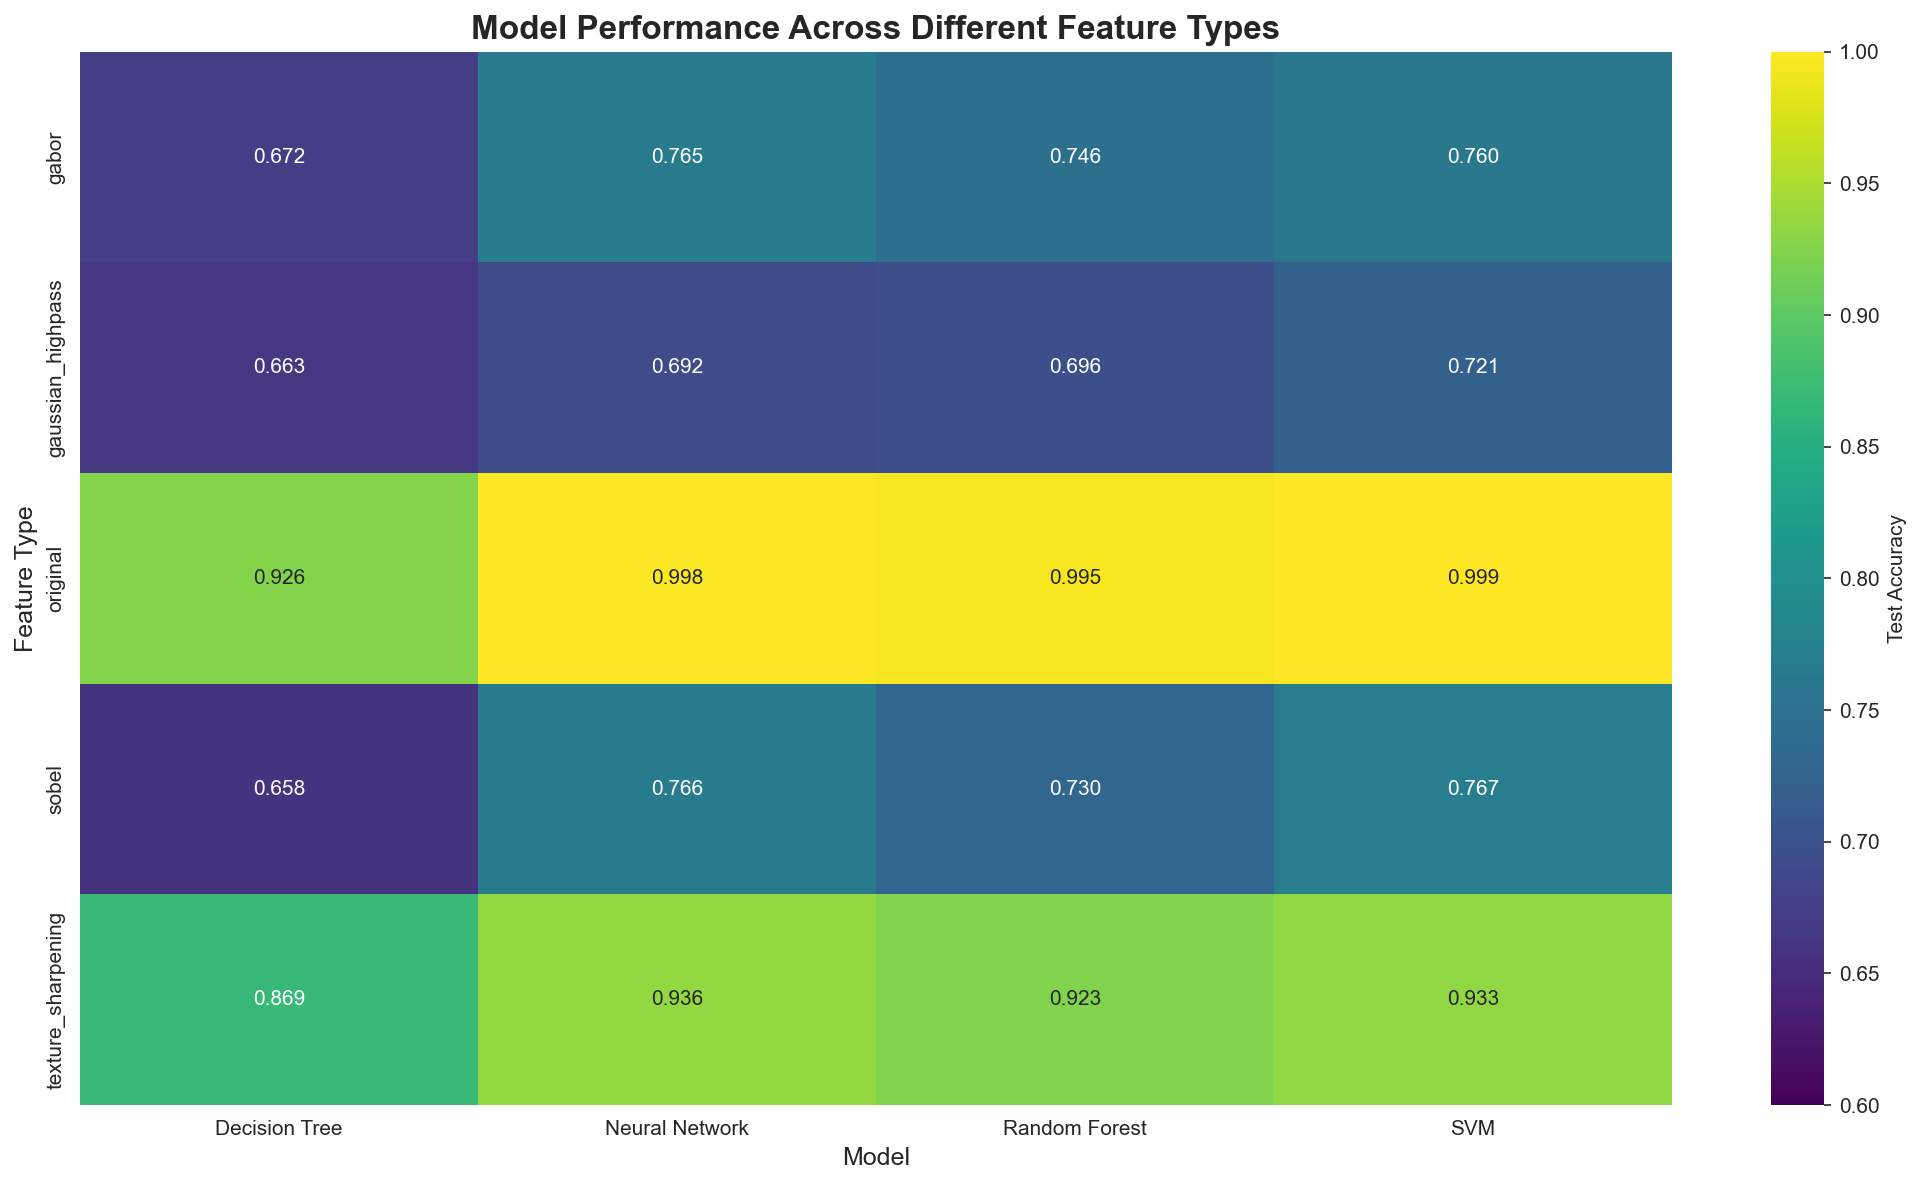

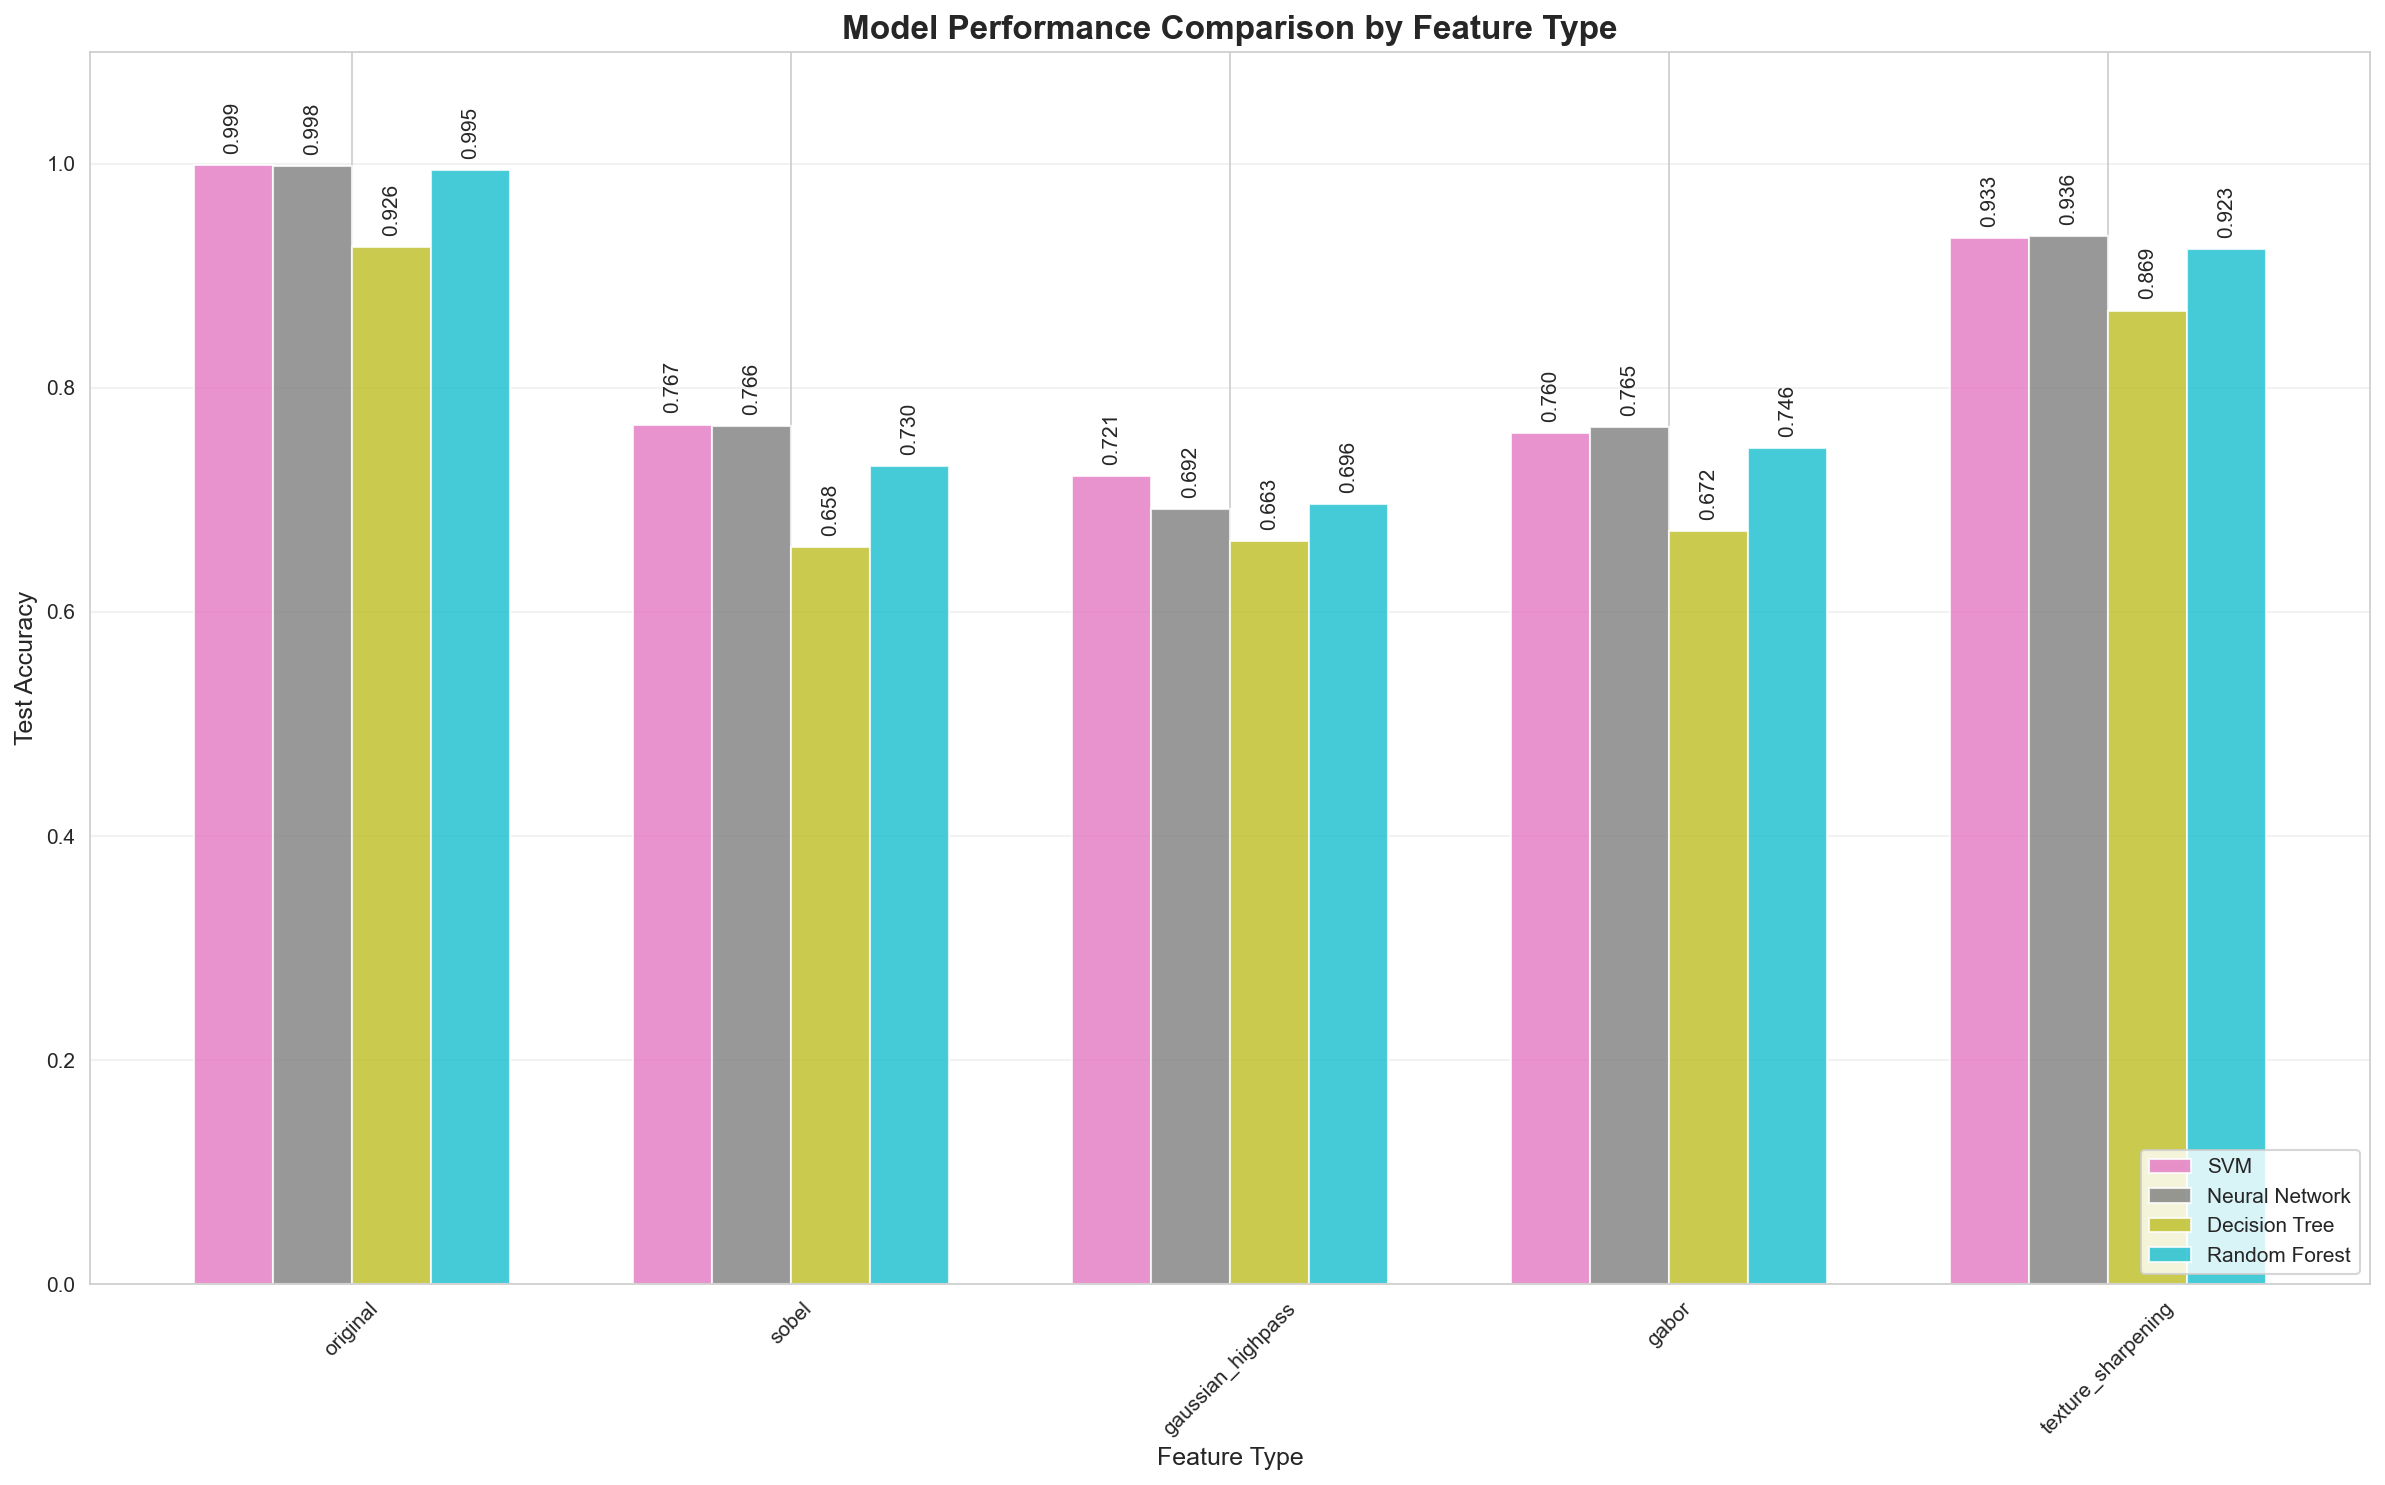

<Figure size 2100x1200 with 0 Axes>

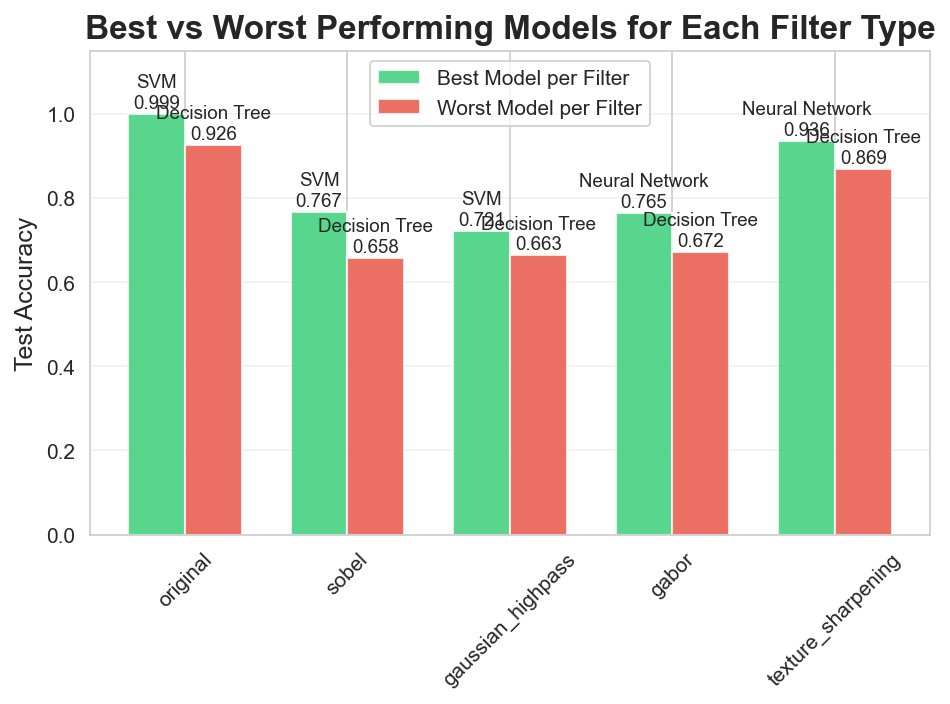

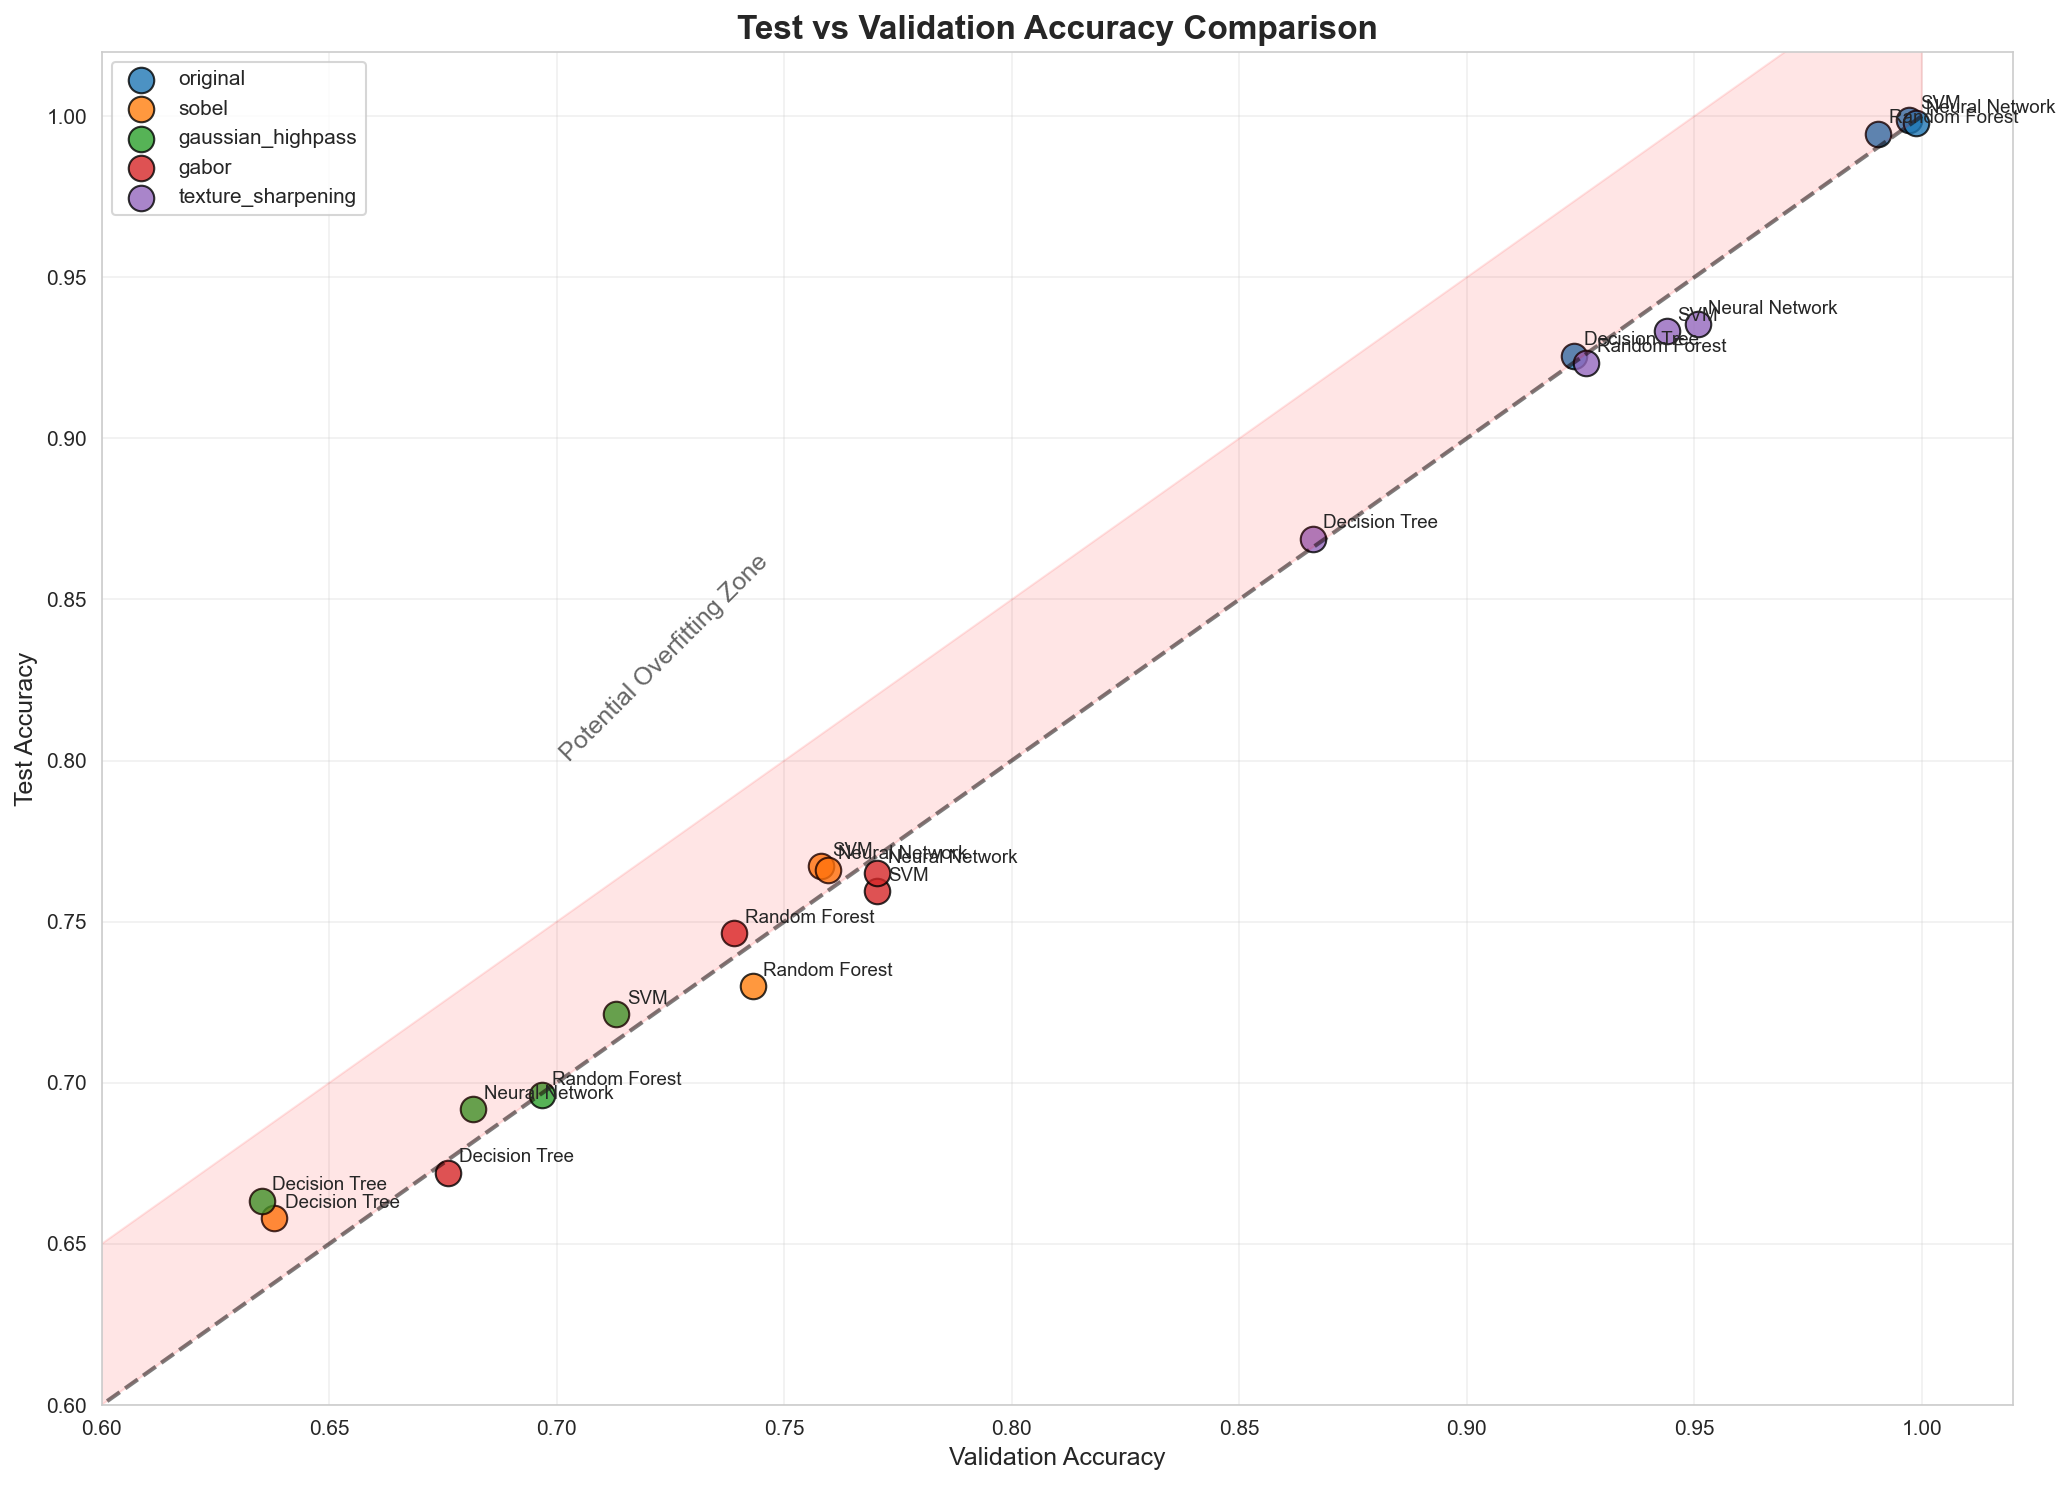

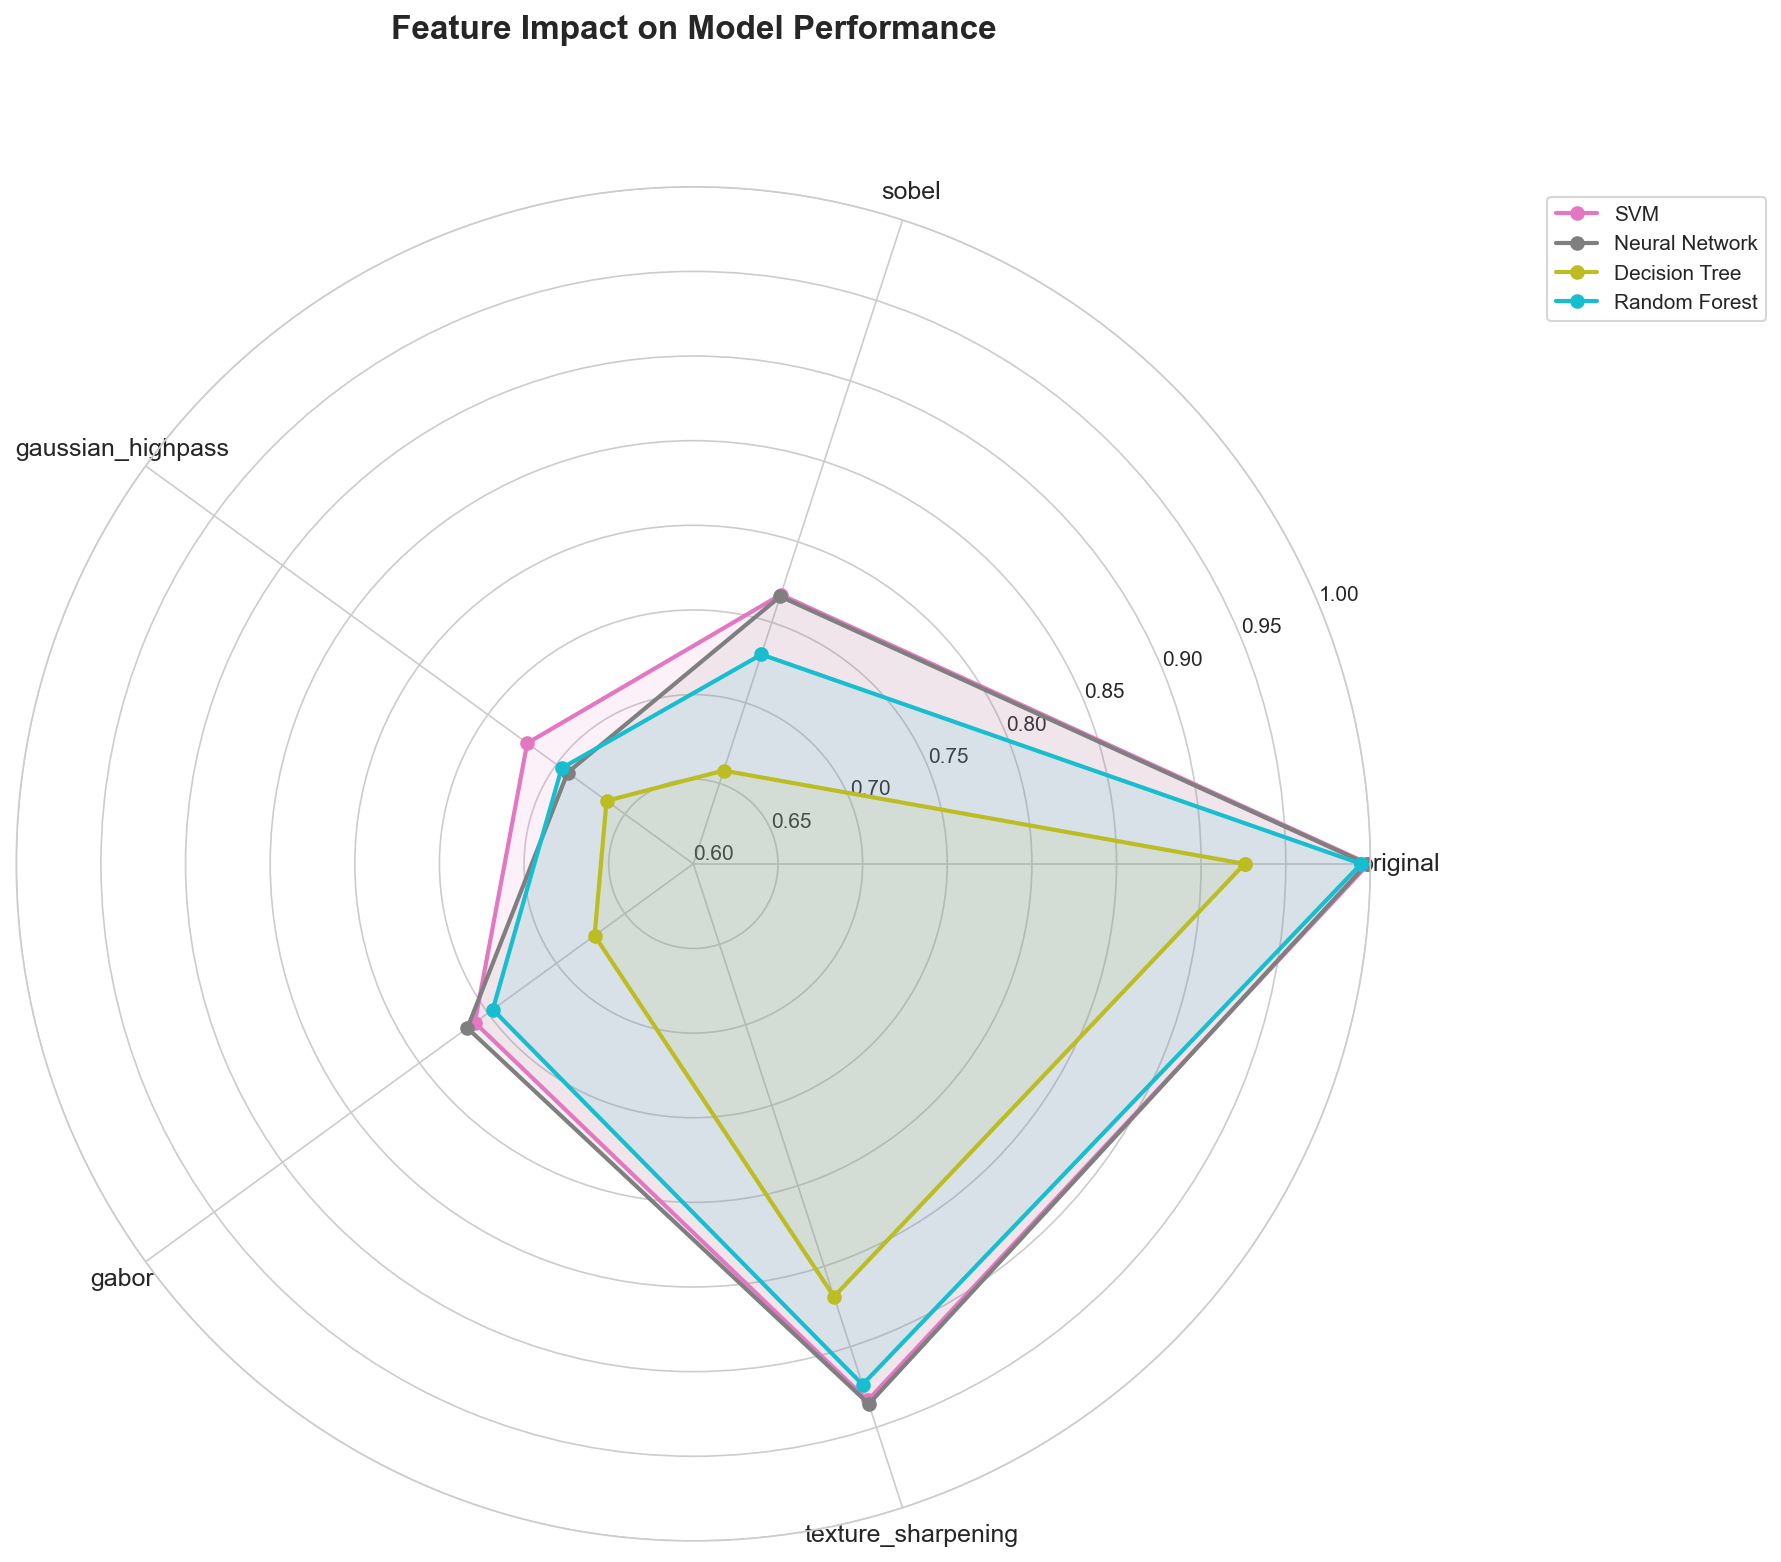

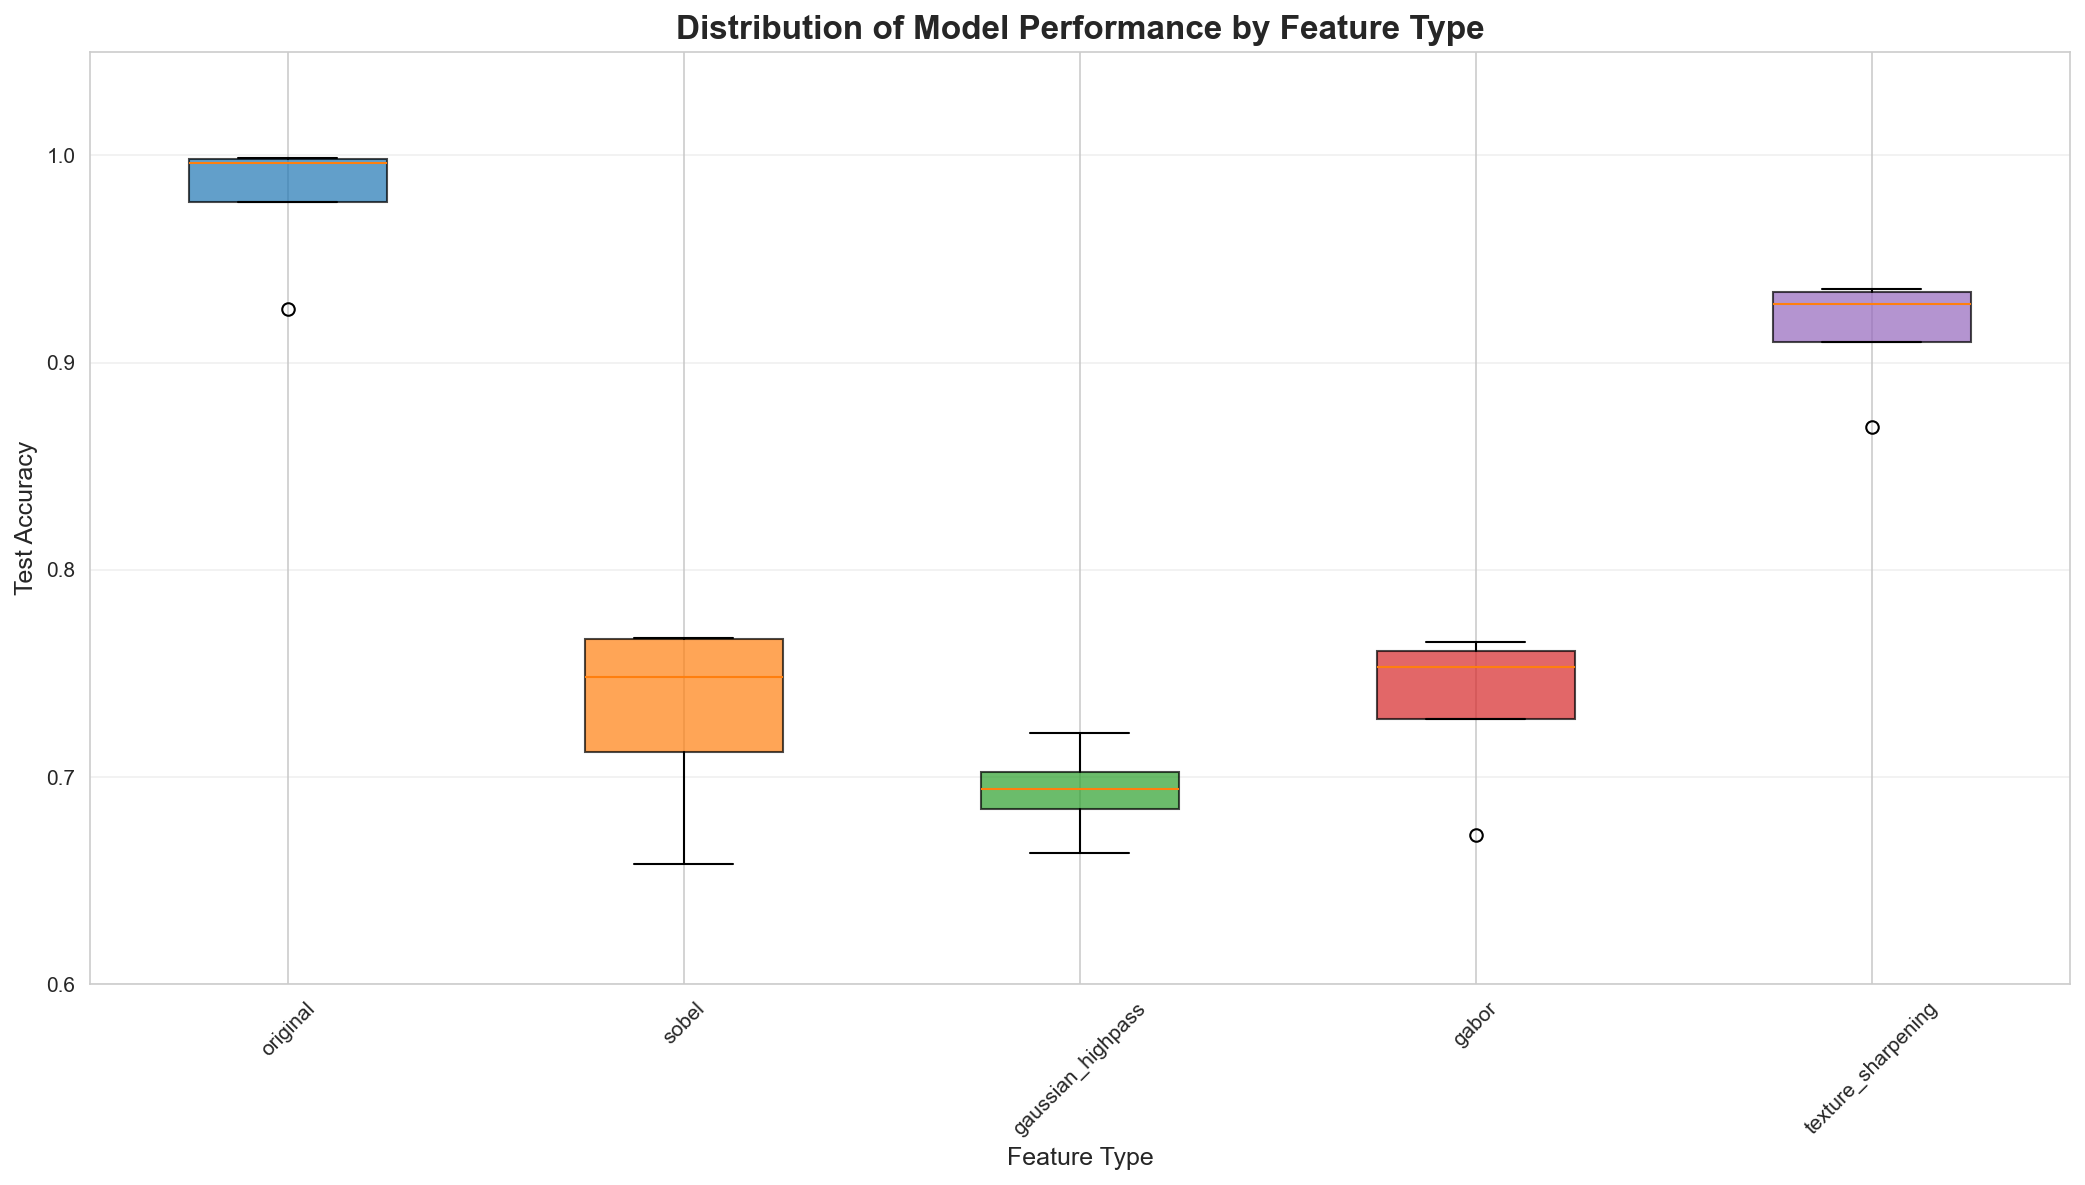

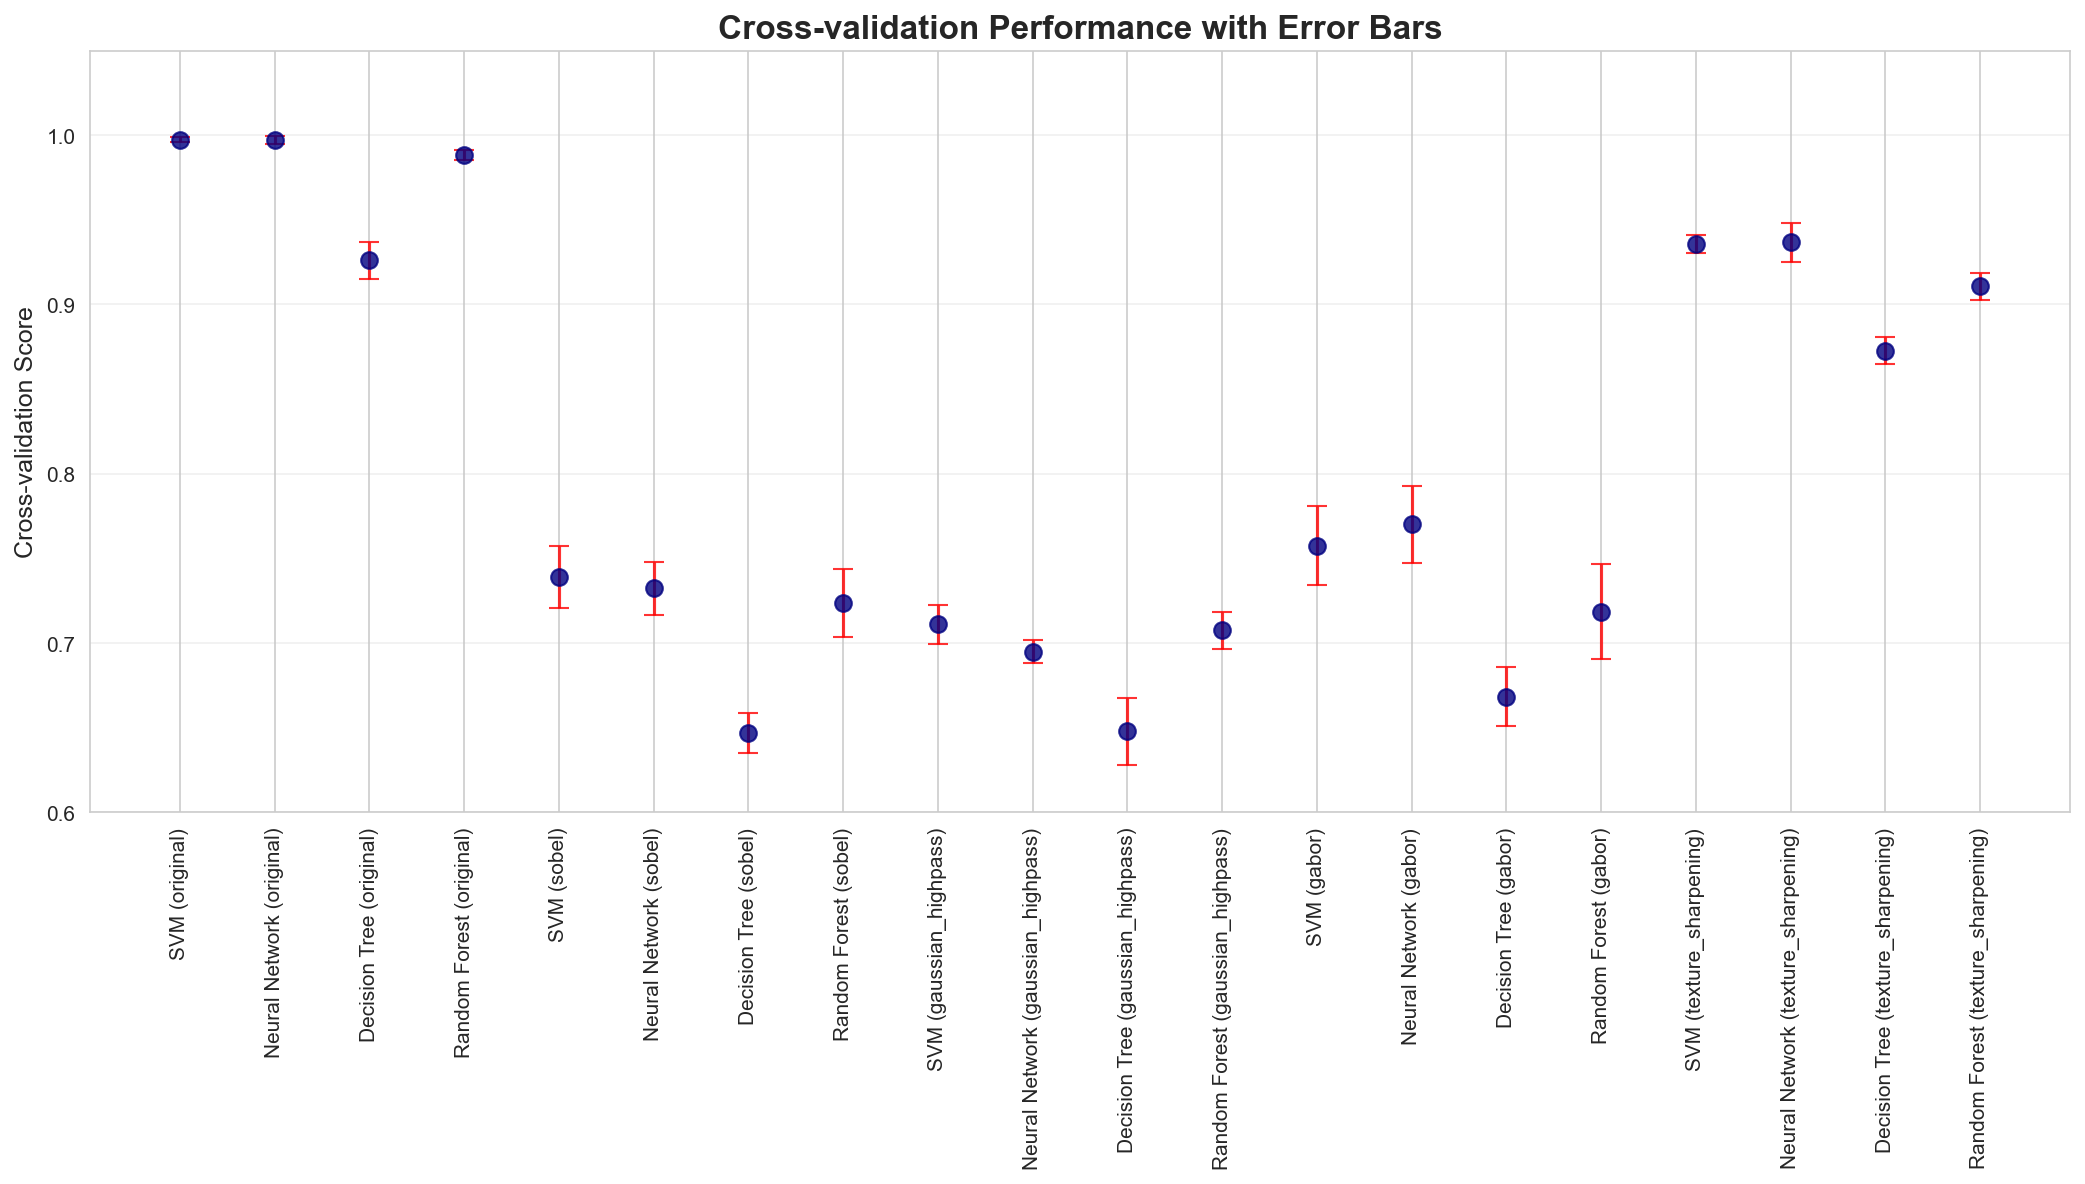

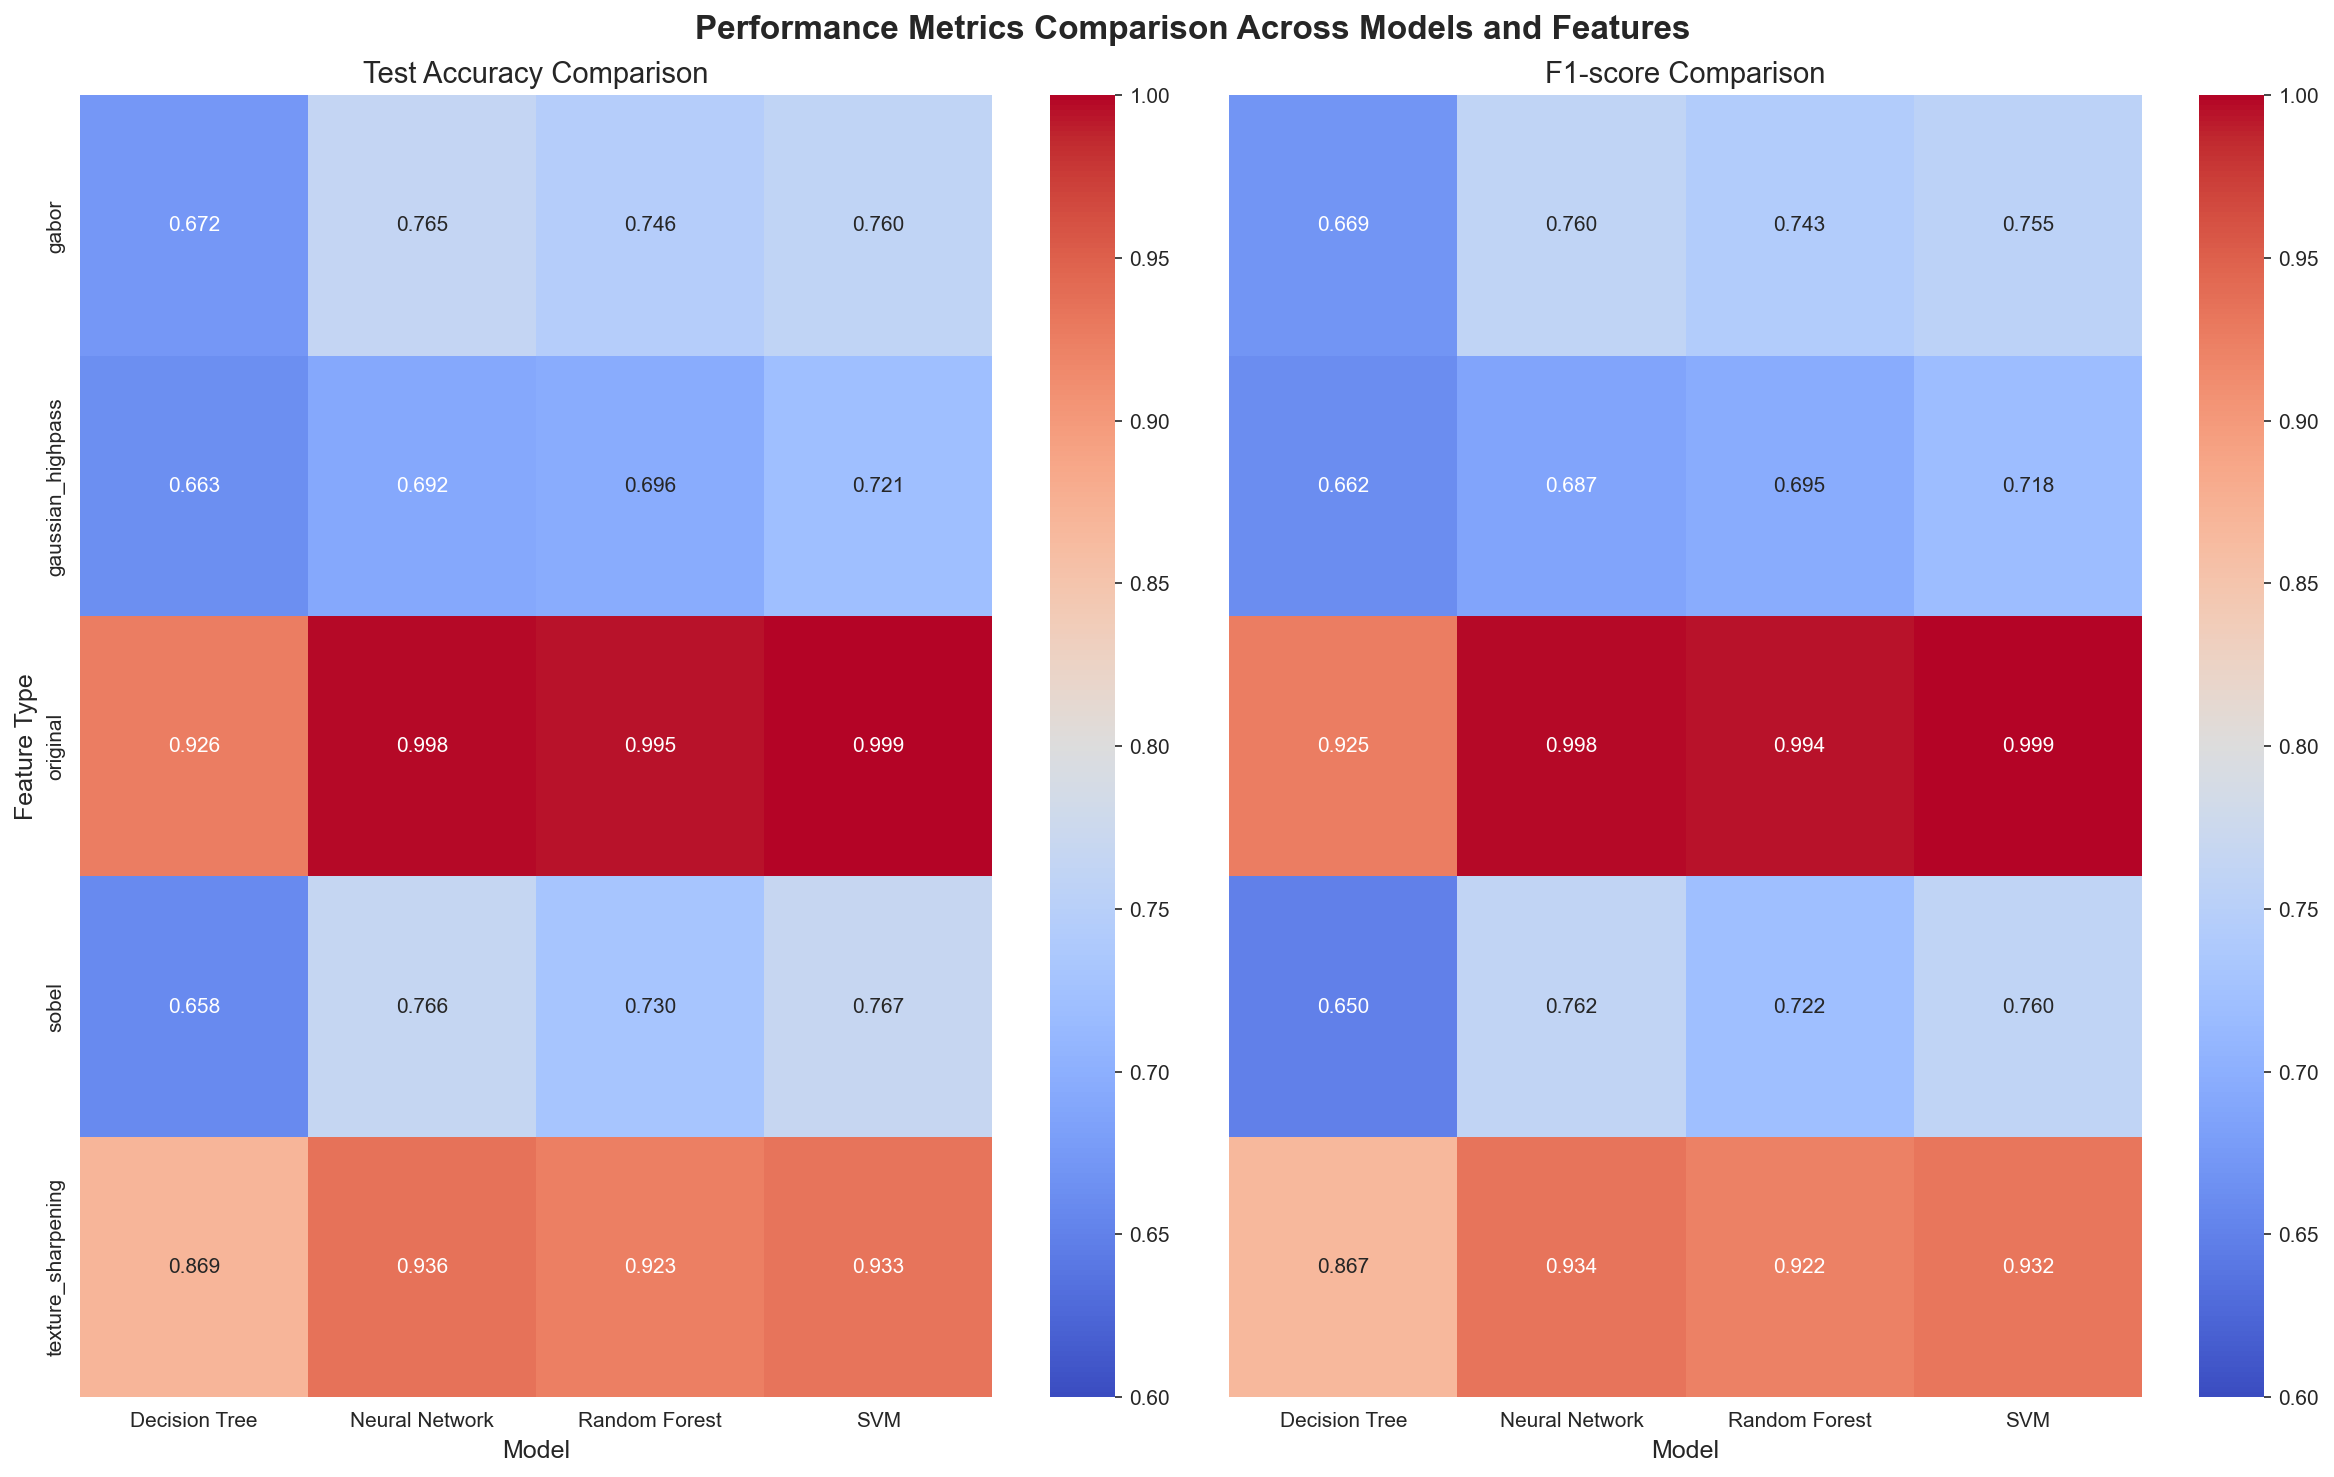

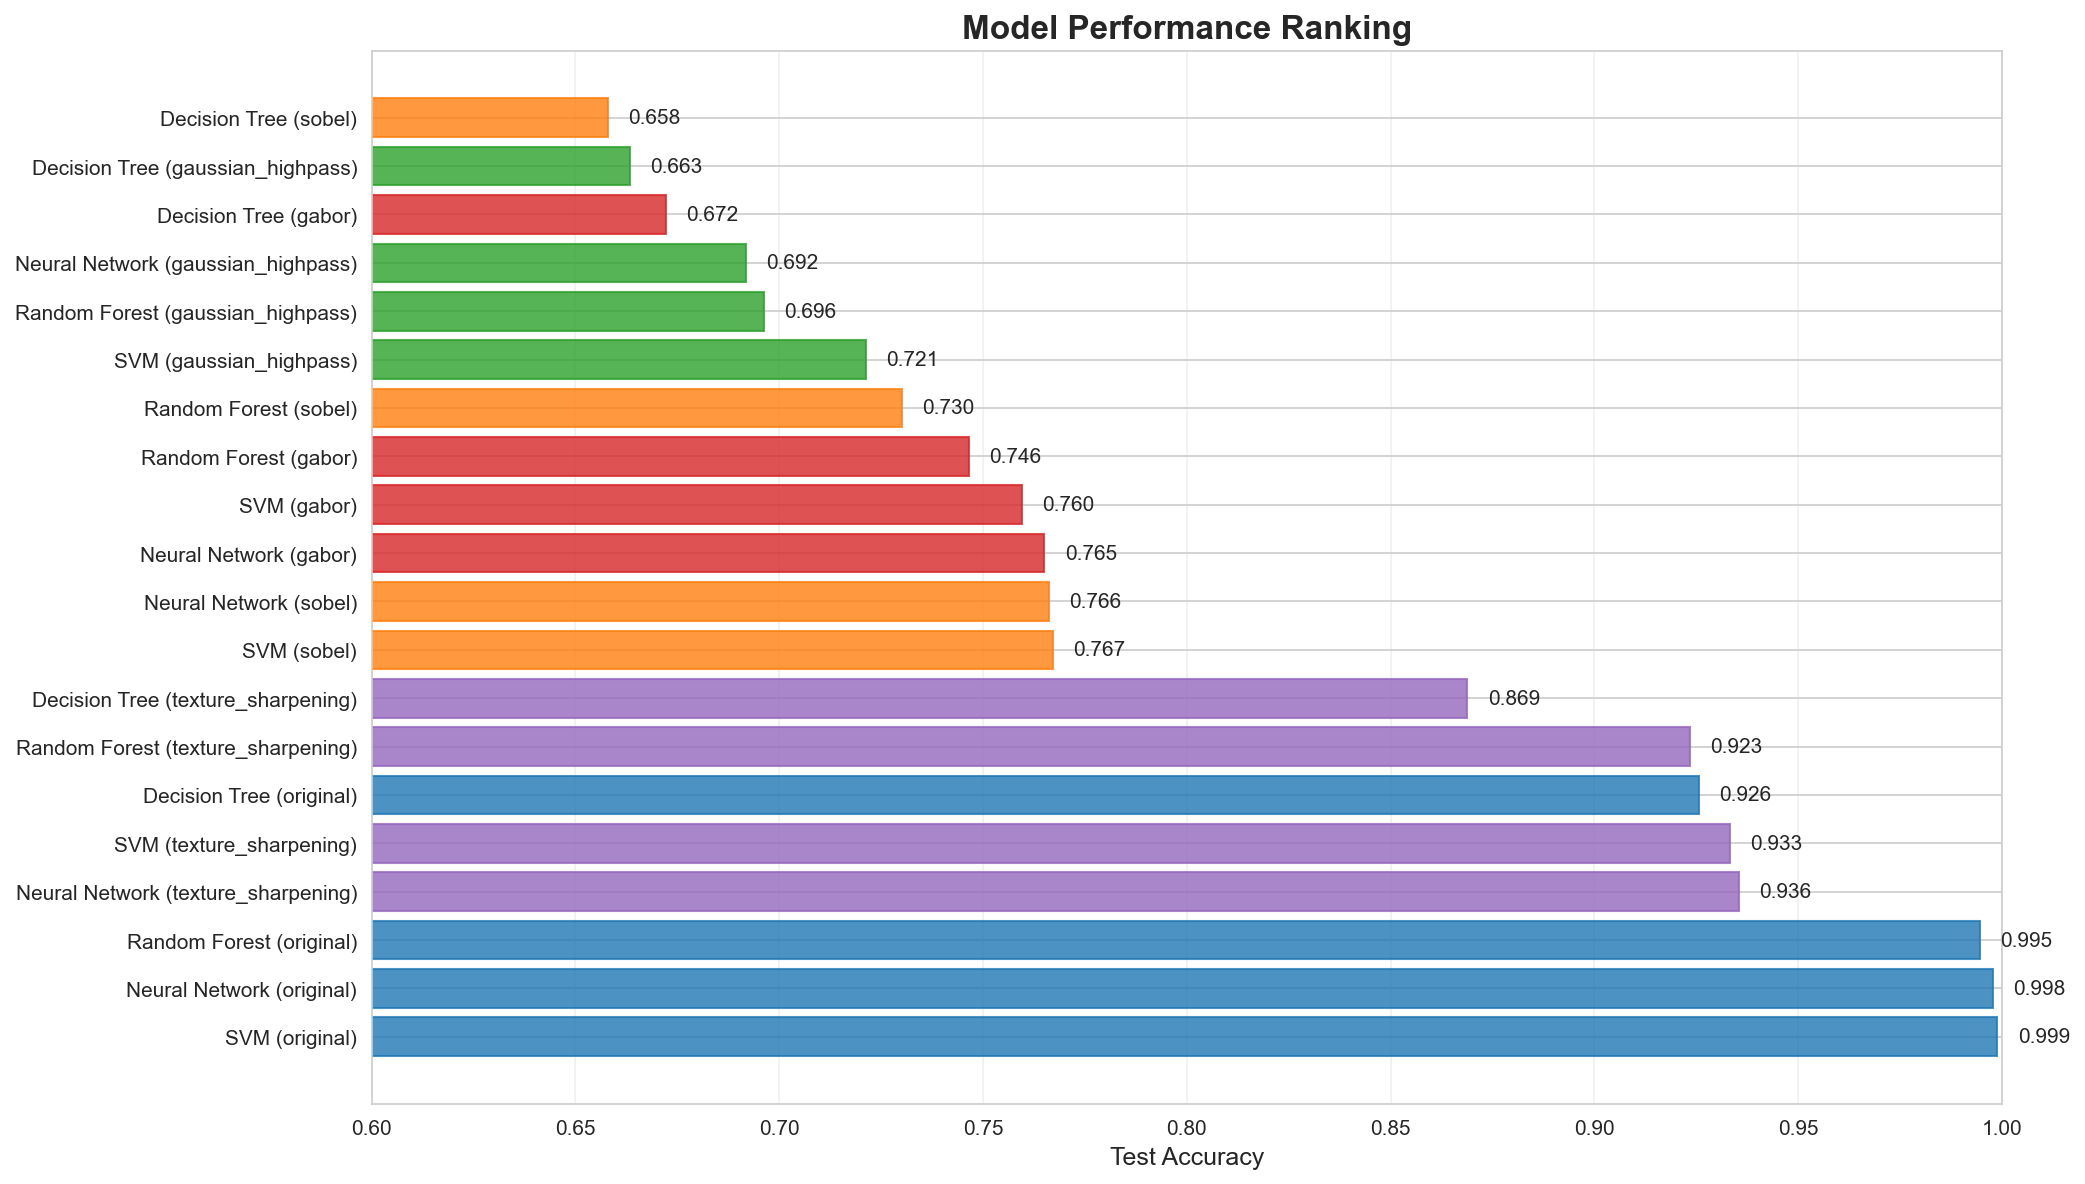

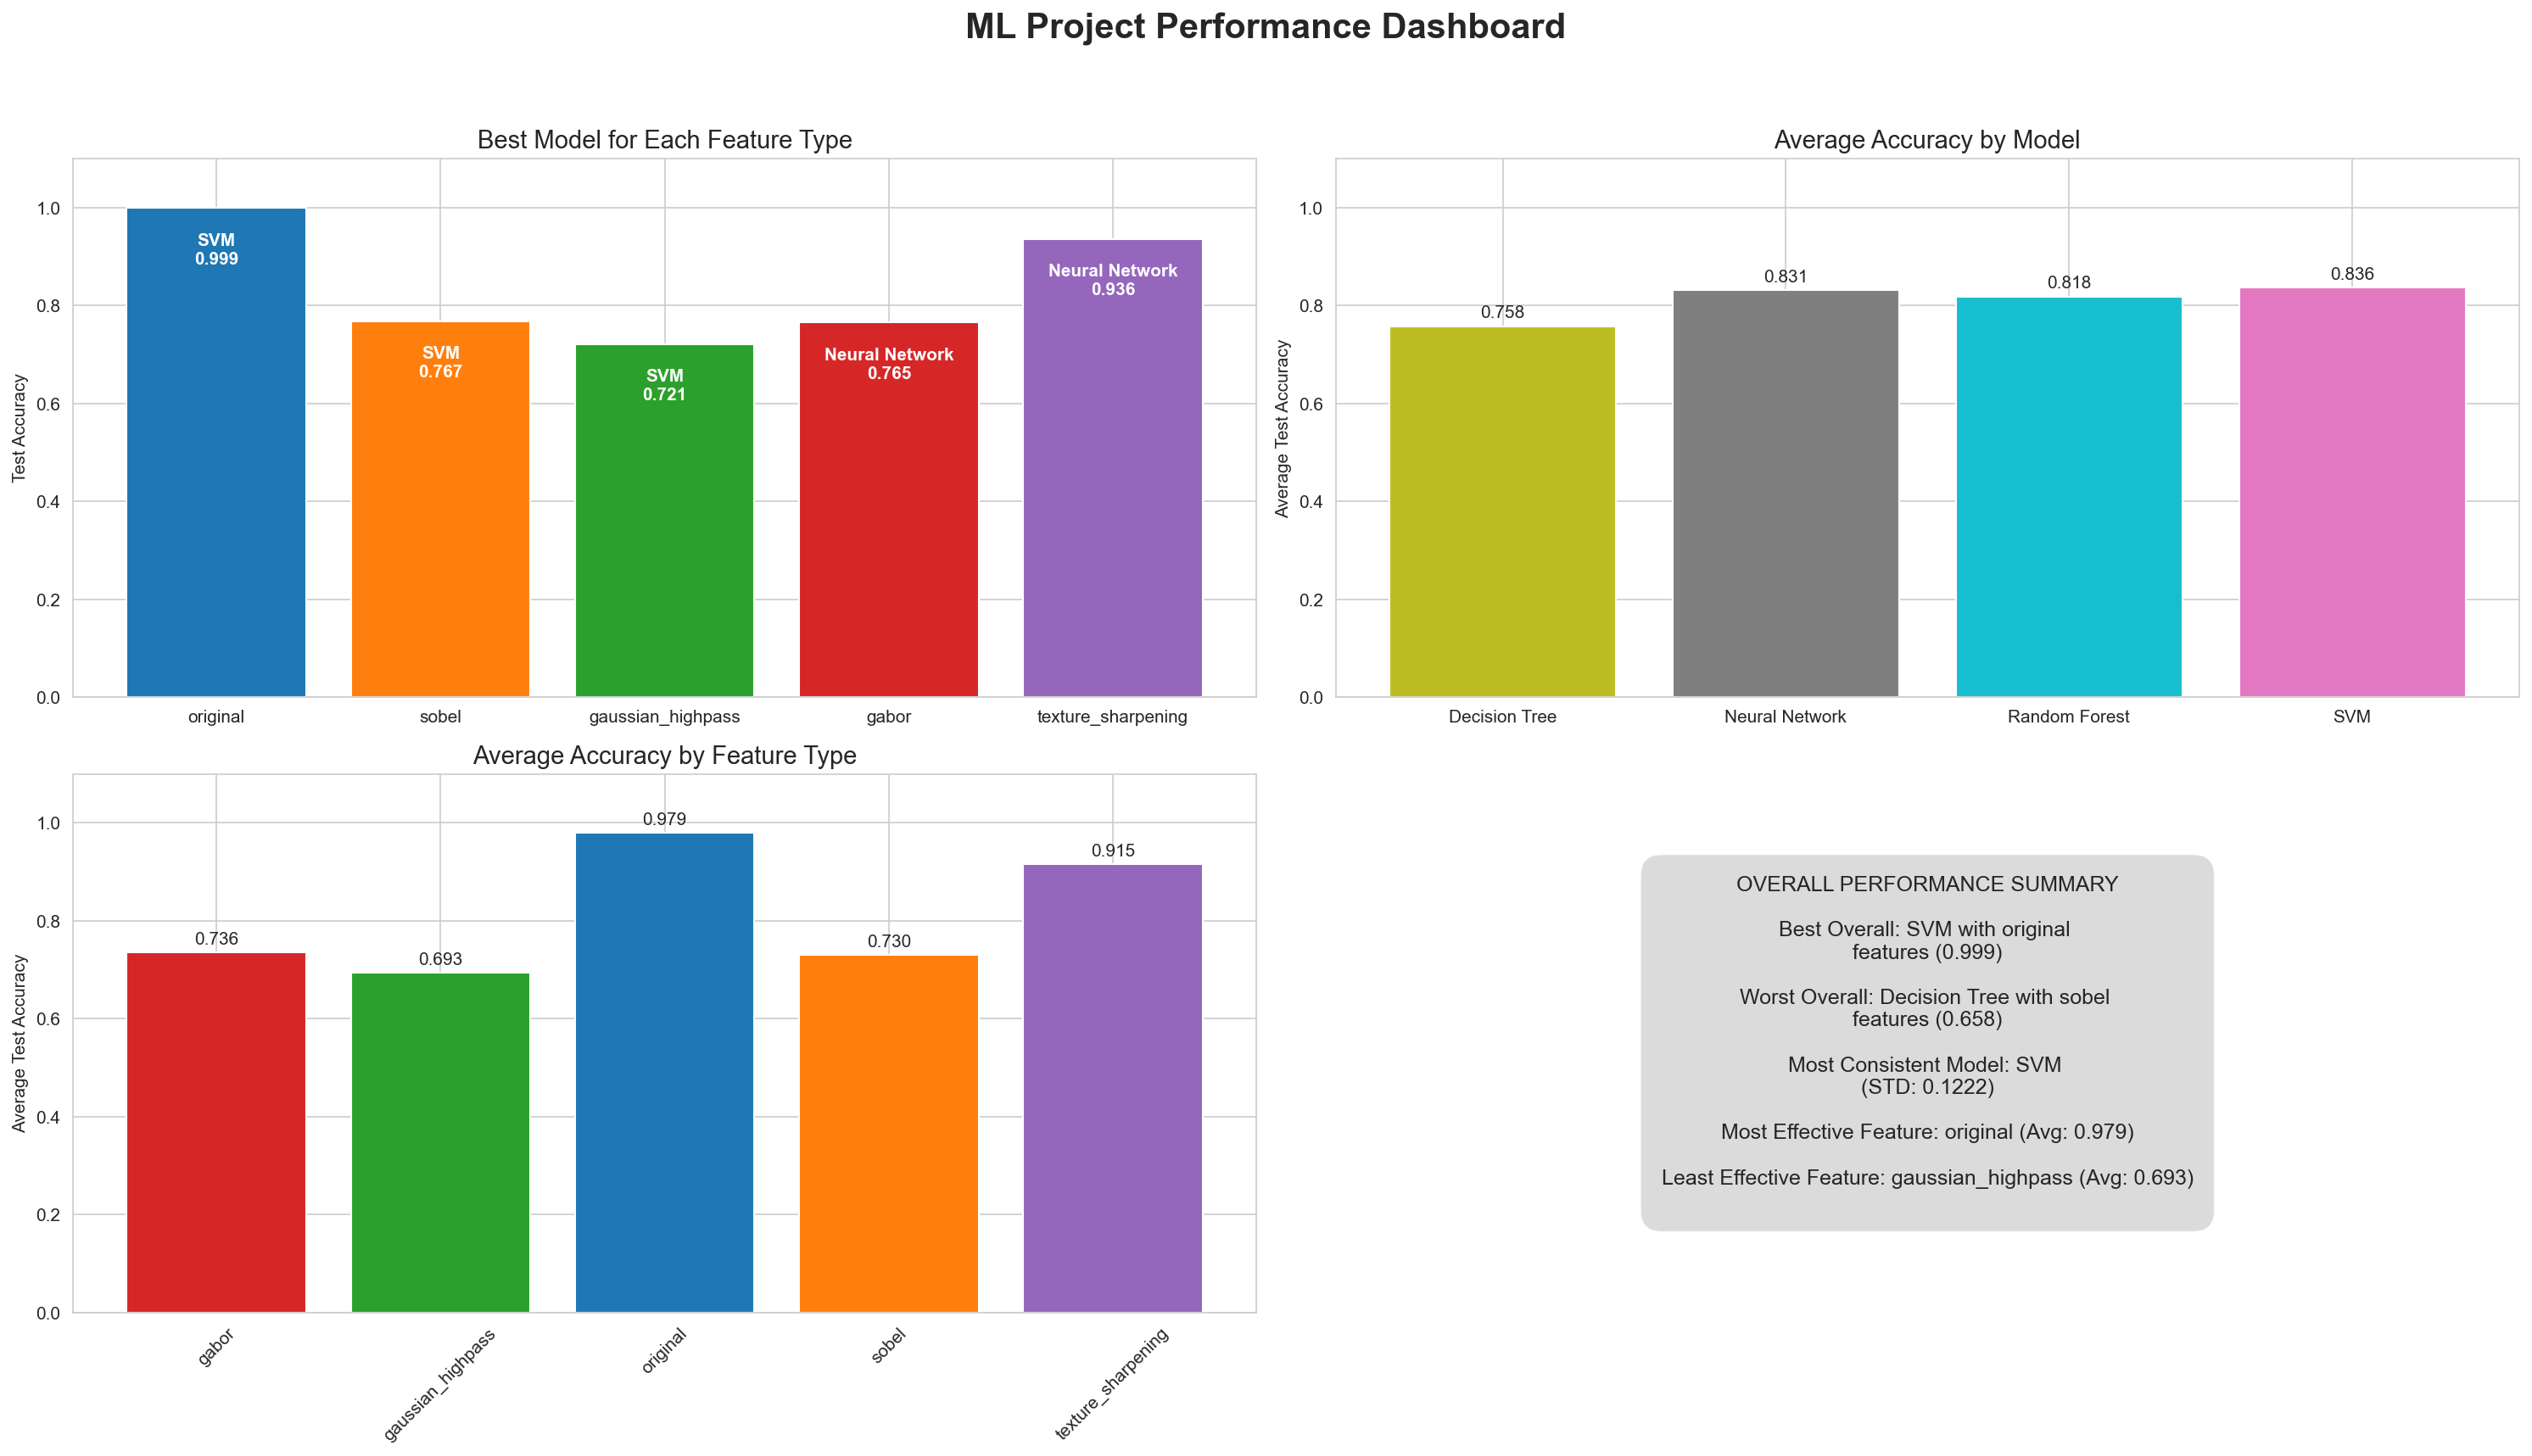


Summary Statistics saved to 'summary_statistics.csv'


'Visualization suite complete! All charts have been generated and saved.'

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches

# Set style for consistent visualizations
plt.style.use('default')  # Changed from 'seaborn' to 'default'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
sns.set_style("whitegrid")  # Use seaborn styling through sns.set_style()

# Initialize figure for the complete visualization suite
def create_visualization_suite(results_df, all_results):
    """Create comprehensive visualization suite with multiple subplots"""
    
    # Define color palettes for consistent styling
    filter_colors = {'original': '#1f77b4', 'sobel': '#ff7f0e', 'gaussian_highpass': '#2ca02c', 
                    'gabor': '#d62728', 'texture_sharpening': '#9467bd'}
    model_colors = {'SVM': '#e377c2', 'Neural Network': '#7f7f7f', 'Decision Tree': '#bcbd22', 
                   'Random Forest': '#17becf'}
    
    # 1. Performance Comparison Heatmap
    plt.figure(figsize=(14, 8))
    
    # Pivot data for heatmap
    heatmap_data = results_df.pivot_table(values='Test Accuracy', 
                                         index='Filter', 
                                         columns='Model')
    
    # Create heatmap
    ax = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', 
                     cbar_kws={'label': 'Test Accuracy'}, vmin=0.6, vmax=1.0)
    plt.title('Model Performance Across Different Feature Types', fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Feature Type', fontsize=12)
    plt.tight_layout()
    plt.savefig('performance_heatmap.png')
    plt.show()
    
    # 2. Filter Comparison Bar Chart
    plt.figure(figsize=(16, 10))
    
    # Create grouped bar chart
    bar_width = 0.18
    x = np.arange(len(results_df['Filter'].unique()))
    
    for i, model in enumerate(results_df['Model'].unique()):
        accuracies = []
        for filter_type in results_df['Filter'].unique():
            data = results_df[(results_df['Filter'] == filter_type) & (results_df['Model'] == model)]
            accuracies.append(data['Test Accuracy'].values[0] if not data.empty else 0)
        
        bars = plt.bar(x + i*bar_width, accuracies, bar_width, label=model, 
                      color=model_colors[model], alpha=0.8)
        
        # Add value labels on bars
        for idx, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{accuracies[idx]:.3f}', ha='center', va='bottom', fontsize=10, 
                    rotation=90)
    
    plt.xlabel('Feature Type', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Model Performance Comparison by Feature Type', fontsize=16, fontweight='bold')
    plt.xticks(x + bar_width*1.5, results_df['Filter'].unique(), rotation=45)
    plt.legend(loc='lower right')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_comparison_by_feature.png')
    plt.show()
    
    # 3. Best and Worst Performance Comparison
    plt.figure(figsize=(14, 8))
    
    best_performers = []
    worst_performers = []
    
    for filter_type in results_df['Filter'].unique():
        filter_data = results_df[results_df['Filter'] == filter_type]
        best = filter_data.loc[filter_data['Test Accuracy'].idxmax()]
        worst = filter_data.loc[filter_data['Test Accuracy'].idxmin()]
        
        best_performers.append(best)
        worst_performers.append(worst)
    
    best_df = pd.DataFrame(best_performers)
    worst_df = pd.DataFrame(worst_performers)
    
    x = np.arange(len(best_df))
    width = 0.35
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, best_df['Test Accuracy'], width, label='Best Model per Filter', 
                   color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, worst_df['Test Accuracy'], width, label='Worst Model per Filter', 
                   color='#e74c3c', alpha=0.8)
    
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Best vs Worst Performing Models for Each Filter Type', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(best_df['Filter'], rotation=45)
    ax.legend()
    
    # Add value labels and model names
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Label best model
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.005, 
                f'{best_df.iloc[i]["Model"]}\n{bar1.get_height():.3f}', 
                ha='center', va='bottom', fontsize=9)
        # Label worst model
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.005, 
                f'{worst_df.iloc[i]["Model"]}\n{bar2.get_height():.3f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.ylim(0, 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('best_worst_comparison.png')
    plt.show()
    
    # 4. Accuracy vs. Validation Accuracy Scatter Plot
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot with different colors for each filter
    for filter_type in results_df['Filter'].unique():
        filter_data = results_df[results_df['Filter'] == filter_type]
        plt.scatter(filter_data['Validation Accuracy'], filter_data['Test Accuracy'], 
                   s=150, alpha=0.8, color=filter_colors[filter_type], label=filter_type, 
                   edgecolors='black', linewidth=1)
        
        # Add model labels
        for idx, row in filter_data.iterrows():
            plt.annotate(row['Model'], 
                        (row['Validation Accuracy'], row['Test Accuracy']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2)
    
    # Add overfitting warning zone
    plt.fill_between([0, 1], [0, 1], [0.05, 1.05], color='red', alpha=0.1)
    plt.text(0.7, 0.8, 'Potential Overfitting Zone', rotation=45, fontsize=12, alpha=0.7)
    
    plt.xlabel('Validation Accuracy', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Test vs Validation Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.xlim(0.6, 1.02)
    plt.ylim(0.6, 1.02)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('test_vs_validation_accuracy.png')
    plt.show()
    
    # 5. Feature Impact Radar Chart
    plt.figure(figsize=(12, 12))
    
    # Extract average performance metrics for each filter
    filters = results_df['Filter'].unique()
    angles = np.linspace(0, 2*np.pi, len(filters), endpoint=False)
    
    # Create radar chart
    ax = plt.subplot(111, polar=True)
    
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        values = []
        
        for filter_type in filters:
            data = model_data[model_data['Filter'] == filter_type]
            if not data.empty:
                values.append(data['Test Accuracy'].values[0])
            else:
                values.append(0)
        
        values = np.concatenate((values, [values[0]]))  # Complete the polygon
        angles_complete = np.concatenate((angles, [angles[0]]))
        
        ax.plot(angles_complete, values, 'o-', linewidth=2, label=model, color=model_colors[model])
        ax.fill(angles_complete, values, alpha=0.1, color=model_colors[model])
    
    ax.set_xticks(angles)
    ax.set_xticklabels(filters, fontsize=12)
    ax.set_ylim(0.6, 1.0)
    ax.set_title('Feature Impact on Model Performance', fontsize=16, fontweight='bold', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    plt.tight_layout()
    plt.savefig('feature_impact_radar.png', bbox_inches='tight')
    plt.show()
    
    # 6. Performance Distribution by Feature Type
    plt.figure(figsize=(14, 8))
    
    # Create box plots for each feature type
    box_data = []
    labels = []
    colors = []
    
    for filter_type in filters:
        filter_data = results_df[results_df['Filter'] == filter_type]['Test Accuracy']
        box_data.append(filter_data)
        labels.append(filter_type)
        colors.append(filter_colors[filter_type])
    
    bp = plt.boxplot(box_data, patch_artist=True, labels=labels)
    
    # Customize box plot colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.xlabel('Feature Type', fontsize=12)
    plt.title('Distribution of Model Performance by Feature Type', fontsize=16, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.ylim(0.6, 1.05)
    plt.tight_layout()
    plt.savefig('performance_distribution.png')
    plt.show()
    
    # 7. Cross-Validation Performance
    plt.figure(figsize=(14, 8))
    
    # Create error bars for cross-validation scores
    cv_means = results_df['CV Mean']
    cv_stds = []
    
    # Extract CV standard deviations from all_results
    for filter_name, models in all_results.items():
        for model_name, metrics in models.items():
            cv_stds.append(metrics['cv_std'])
    
    model_filter_labels = [f"{row['Model']} ({row['Filter']})" for _, row in results_df.iterrows()]
    
    plt.errorbar(range(len(cv_means)), cv_means, yerr=cv_stds, fmt='o', capsize=5, color='navy', 
                 ecolor='red', alpha=0.8, markersize=8)
    
    plt.xticks(range(len(model_filter_labels)), model_filter_labels, rotation=90)
    plt.ylabel('Cross-validation Score', fontsize=12)
    plt.title('Cross-validation Performance with Error Bars', fontsize=16, fontweight='bold')
    plt.ylim(0.6, 1.05)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('cross_validation_performance.png')
    plt.show()
    
    # 8. Metric Comparison (Accuracy, F1)
    plt.figure(figsize=(16, 10))
    
    metrics = ['Test Accuracy', 'F1-score']
    n_metrics = len(metrics)
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, n_metrics, i+1)
        
        pivot_data = results_df.pivot_table(values=metric, index='Filter', columns='Model')
        
        sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt='.3f', vmin=0.6, vmax=1.0)
        plt.title(f'{metric} Comparison', fontsize=14)
        
        if i == 0:
            plt.ylabel('Feature Type', fontsize=12)
        else:
            plt.ylabel('')
            plt.yticks([])
        
        plt.xlabel('Model', fontsize=12)
    
    plt.suptitle('Performance Metrics Comparison Across Models and Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('metric_comparison.png')
    plt.show()
    
    # 9. Model Ranking
    plt.figure(figsize=(14, 8))
    
    # Sort by test accuracy
    results_sorted = results_df.sort_values('Test Accuracy', ascending=False)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(results_sorted))
    
    bars = plt.barh(y_pos, results_sorted['Test Accuracy'], align='center', alpha=0.8)
    
    # Color bars by filter type
    for idx, bar in enumerate(bars):
        filter_type = results_sorted.iloc[idx]['Filter']
        bar.set_color(filter_colors[filter_type])
    
    plt.yticks(y_pos, [f"{row['Model']} ({row['Filter']})" for _, row in results_sorted.iterrows()])
    plt.xlabel('Test Accuracy', fontsize=12)
    plt.title('Model Performance Ranking', fontsize=16, fontweight='bold')
    plt.xlim(0.6, 1.0)
    
    # Add value labels
    for idx, value in enumerate(results_sorted['Test Accuracy']):
        plt.text(value + 0.005, idx, f'{value:.3f}', va='center', fontsize=10)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_ranking.png')
    plt.show()
    
    # 10. Performance Summary Dashboard
    plt.figure(figsize=(20, 12))
    
    # Create a 2x2 grid layout
    gs = plt.GridSpec(2, 2, figure=plt.gcf())
    
    # Plot 1: Best model for each filter
    ax1 = plt.subplot(gs[0, 0])
    best_per_filter = []
    for filter_type in filters:
        filter_data = results_df[results_df['Filter'] == filter_type]
        best = filter_data.loc[filter_data['Test Accuracy'].idxmax()]
        best_per_filter.append(best)
    
    best_df = pd.DataFrame(best_per_filter)
    bars = ax1.bar(best_df['Filter'], best_df['Test Accuracy'], color=[filter_colors[f] for f in best_df['Filter']])
    
    for i, bar in enumerate(bars):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05, 
                f"{best_df.iloc[i]['Model']}\n{bar.get_height():.3f}", 
                ha='center', va='top', fontsize=10, color='white', fontweight='bold')
    
    ax1.set_title('Best Model for Each Feature Type', fontsize=14)
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel('Test Accuracy')
    
    # Plot 2: Average accuracy by model
    ax2 = plt.subplot(gs[0, 1])
    avg_by_model = results_df.groupby('Model')['Test Accuracy'].mean()
    bars = ax2.bar(avg_by_model.index, avg_by_model.values, color=[model_colors[m] for m in avg_by_model.index])
    
    for i, bar in enumerate(bars):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Accuracy by Model', fontsize=14)
    ax2.set_ylim(0, 1.1)
    ax2.set_ylabel('Average Test Accuracy')
    
    # Plot 3: Feature effectiveness
    ax3 = plt.subplot(gs[1, 0])
    avg_by_filter = results_df.groupby('Filter')['Test Accuracy'].mean()
    bars = ax3.bar(avg_by_filter.index, avg_by_filter.values, color=[filter_colors[f] for f in avg_by_filter.index])
    
    for i, bar in enumerate(bars):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)
    
    ax3.set_title('Average Accuracy by Feature Type', fontsize=14)
    ax3.set_ylim(0, 1.1)
    ax3.set_ylabel('Average Test Accuracy')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Summary statistics table
    ax4 = plt.subplot(gs[1, 1])
    ax4.axis('off')
    
    summary_text = f"""OVERALL PERFORMANCE SUMMARY

Best Overall: {results_sorted.iloc[0]['Model']} with {results_sorted.iloc[0]['Filter']} 
features ({results_sorted.iloc[0]['Test Accuracy']:.3f})

Worst Overall: {results_sorted.iloc[-1]['Model']} with {results_sorted.iloc[-1]['Filter']} 
features ({results_sorted.iloc[-1]['Test Accuracy']:.3f})

Most Consistent Model: {results_df.groupby('Model')['Test Accuracy'].std().idxmin()} 
(STD: {results_df.groupby('Model')['Test Accuracy'].std().min():.4f})

Most Effective Feature: {avg_by_filter.idxmax()} (Avg: {avg_by_filter.max():.3f})

Least Effective Feature: {avg_by_filter.idxmin()} (Avg: {avg_by_filter.min():.3f})
"""
    
    ax4.text(0.5, 0.5, summary_text, ha='center', va='center', bbox=dict(boxstyle="round,pad=1", 
                facecolor='lightgray', alpha=0.8), fontsize=12, transform=ax4.transAxes)
    
    plt.suptitle('ML Project Performance Dashboard', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 11. Summary Statistics Table (for presentation)
    summary_stats = results_df.groupby(['Filter', 'Model']).agg({
        'Test Accuracy': ['mean', 'std'],
        'F1-score': ['mean', 'std'],
        'CV Mean': ['mean', 'std']
    }).round(4)
    
    summary_stats.to_csv('summary_statistics.csv')
    print("\nSummary Statistics saved to 'summary_statistics.csv'")
    
    return "Visualization suite complete! All charts have been generated and saved."

# Use this if your data is already in a pandas DataFrame
def process_existing_results():
    """Use this function to process results from your CSV file"""
    try:
        # Load the results
        results_df = pd.read_csv('comprehensive_results_summary.csv')
        
        # Create dummy all_results structure for the error bars
        all_results = {}
        for filter_type in results_df['Filter'].unique():
            all_results[filter_type] = {}
            for model in results_df['Model'].unique():
                # Use 0.01 as a default standard deviation if not available
                all_results[filter_type][model] = {'cv_std': 0.01}
        
        # Create the visualization suite
        create_visualization_suite(results_df, all_results)
        
    except FileNotFoundError:
        print("Please ensure 'comprehensive_results_summary.csv' exists in the current directory")
    except Exception as e:
        print(f"An error occurred: {e}")

# If you have your data in different format, convert it first
def convert_results_to_dataframe(your_data_structure):
    """Convert your specific data structure to the required DataFrame format"""
    # Example conversion - adjust based on your actual data structure
    results_list = []
    
    # Assuming your_data_structure is similar to the all_results dictionary
    for filter_type, models in your_data_structure.items():
        for model_name, metrics in models.items():
            result = {
                'Filter': filter_type,
                'Model': model_name,
                'Test Accuracy': metrics.get('accuracy', 0),
                'Validation Accuracy': metrics.get('val_accuracy', 0),
                'CV Mean': metrics.get('cv_mean', 0),
                'F1-score': metrics.get('f1', 0),
            }
            results_list.append(result)
    
    return pd.DataFrame(results_list)

results_df = pd.read_csv('comprehensive_results_summary.csv')
create_visualization_suite(results_df, all_results)